(c) Copyright 2019 Le Losq et al.

# Supplementary Code

**Le Losq, Berry, Kendrick, Neuville, O'Neill, Determination of the oxidation state of iron in Mid-Ocean Ridge basalt glasses by Raman spectroscopy, American Mineralogist**

Code tested in Python 3.6. It will not work in Python 2.7 as I use unpacking in calls of functions for instance.

Dependencies:
 - scipy
 - sklearn
 - numpy
 - uncertainties
 - pandas and xlrd (check that the later is installed)
 - matplotlib
 - rampy (v0.4.1 or later) and gcvspline (v0.4 or later)
 - cvxpy v1.0 or later
 - PyMCR v0.3.0
 - Figures use Tex rendering so probably need a LaTex distribution installed. (can be turned off in the rc.param definition of matplotlib)
 
**A copy of this code will also be hosted on https://github.com/charlesll/rampy/examples/Iron_MORB/** On the long term, any code improvement will be posted at this address.
 
# Importing the libraries

In [1]:
# Library import
%matplotlib inline
import scipy
import numpy as np
np.random.seed(seed=42) # fix the random seed for reproducible results

import scipy.optimize as op
import uncertainties # we use the package uncertainties to handle the uncertainties and their correlations
import uncertainties.unumpy as un
from uncertainties import ufloat

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.decomposition import NMF
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

import pandas as pd
import rampy as rp
import cvxpy

import iron # the local module that contains data treatment functions

from pymcr.mcr import McrAR as McrAls
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm

# style for the plots
matplotlib.rcParams['figure.figsize'] = 3.22, 3.22
matplotlib.rcParams['font.size']= 10
matplotlib.rcParams['font.family']= "sans-serif"
matplotlib.rcParams['font.sans-serif']= "Arial"

matplotlib.rcParams['axes.labelsize']= 12
matplotlib.rcParams['axes.titlesize']= 12

matplotlib.rcParams['xtick.labelsize']= 10
matplotlib.rcParams['ytick.labelsize']= 10

matplotlib.rcParams['lines.markersize']= 8
matplotlib.rcParams['lines.linewidth']= 1.0
 
matplotlib.rcParams['legend.fontsize']= 9
matplotlib.rcParams['legend.frameon']= True
matplotlib.rcParams['legend.markerscale']= 1.0
matplotlib.rcParams['legend.handletextpad']= 0.5

matplotlib.rcParams['text.usetex']= True

# Import of glass standard dataset

In [2]:
liste_standards = pd.read_excel("./MORB_datalist.xlsx", sheet_name="standards")

# preparing the data for the standards
x, raw_record, bas2_std, x_fit, y_fit_nosmo, y_fit, nb_exp = iron.preparing_data(liste_standards,cutoff=np.array([850.,1140.]))

# getting the sample redox ratio
fe3_standards = liste_standards["Fe3_moss"]

#getting the sample log fO2
fo2 = liste_standards["logfo2"]

# getting the mean values of the spectra and the cutoff baseline
mean_record = np.ones((x.shape[0],int(nb_exp/5)))
mean_y_fit = np.ones((y_fit.shape[0],int(nb_exp/5)))
mean_bas2_std = np.ones((len(x),int(nb_exp/5)))
counter = 0
for i in range(0,nb_exp,5):
    mean_record[:,counter]=np.mean(raw_record[:,i:i+5],1)
    mean_y_fit[:,counter]=np.mean(y_fit[:,i:i+5],1)
    mean_bas2_std[:,counter]=np.mean(bas2_std[:,i:i+5],1)
    counter = counter+1

mean_fo2 = liste_standards["logfo2"].iloc[range(0,nb_exp,5)].values
mean_fe3 = liste_standards["Fe3_moss"].iloc[range(0,nb_exp,5)].values

# Figure 1

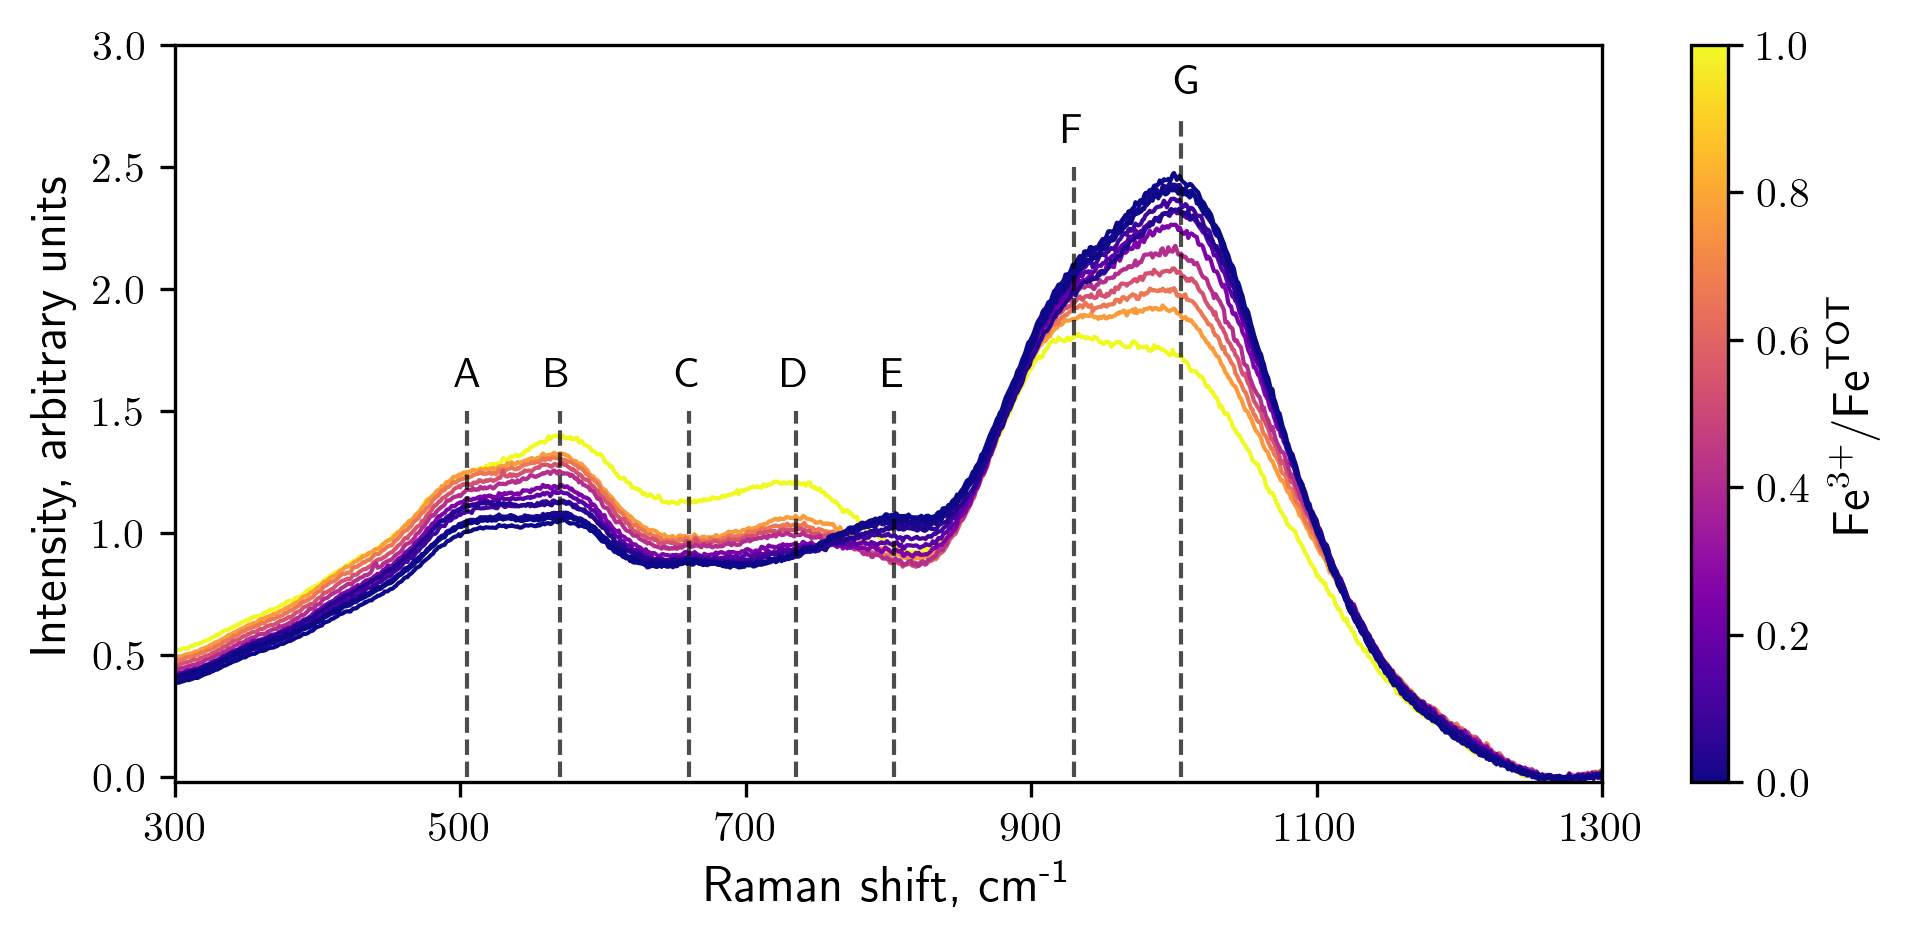

In [3]:
# Figure 1
scale_fig = 1000.
fig1 = plt.figure(figsize=(6.73,3.24),dpi=300)

# taken from https://stackoverflow.com/questions/26545897/drawing-a-colorbar-aside-a-line-plot-using-matplotlib?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
# mean_fe: an array of parameters, each of our curves depend on a specific
# value of parameters

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(mean_fe3),
    vmax=np.max(mean_fe3))

# choose a colormap
c_m = matplotlib.cm.plasma

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm
for i in range(mean_fe3.shape[0]):
    plt.plot(x,
             mean_record[:,i],
             color=s_m.to_rgba(mean_fe3[i]))

# we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m)
c_bar.set_label(r"Fe$^{3+}$/Fe\textsuperscript{TOT}")
    
plt.plot([505,505], [0.,1.5],"--",color="black",alpha=0.7)
plt.plot([570,570], [0.,1.5],"--",color="black",alpha=0.7)
plt.plot([660,660], [0.,1.5],"--",color="black",alpha=0.7)
plt.plot([735,735], [0.,1.5],"--",color="black",alpha=0.7)
plt.plot([804,804], [0.,1.5],"--",color="black",alpha=0.7)
plt.plot([930,930], [0.,2.5],"--",color="black",alpha=0.7)
plt.plot([1005,1005], [0.,2.7],"--",color="black",alpha=0.7)

plt.annotate("A",xy=(505,1.6),color="black",ha="center",xycoords="data")
plt.annotate("B",xy=(570,1.6),color="black",ha="center",xycoords="data")
plt.annotate("C",xy=(660,1.6),color="black",ha="center",xycoords="data")
plt.annotate("D",xy=(735,1.6),color="black",ha="center",xycoords="data")
plt.annotate("E",xy=(804,1.6),color="black",ha="center",xycoords="data")
plt.annotate("F",xy=(930,2.6),color="black",ha="center",xycoords="data")
plt.annotate("G",xy=(1010,2.8),color="black",ha="center",xycoords="data")

plt.xlabel(r"Raman shift, cm\textsuperscript{-1}")
plt.ylabel("Intensity, arbitrary units")
plt.xticks((300,500,700,900,1100,1300))
plt.xlim(300,1300); plt.ylim(-0.02,3.0)

plt.tight_layout()
fig1.savefig("./figures/Figure1.pdf")

# Figure 2

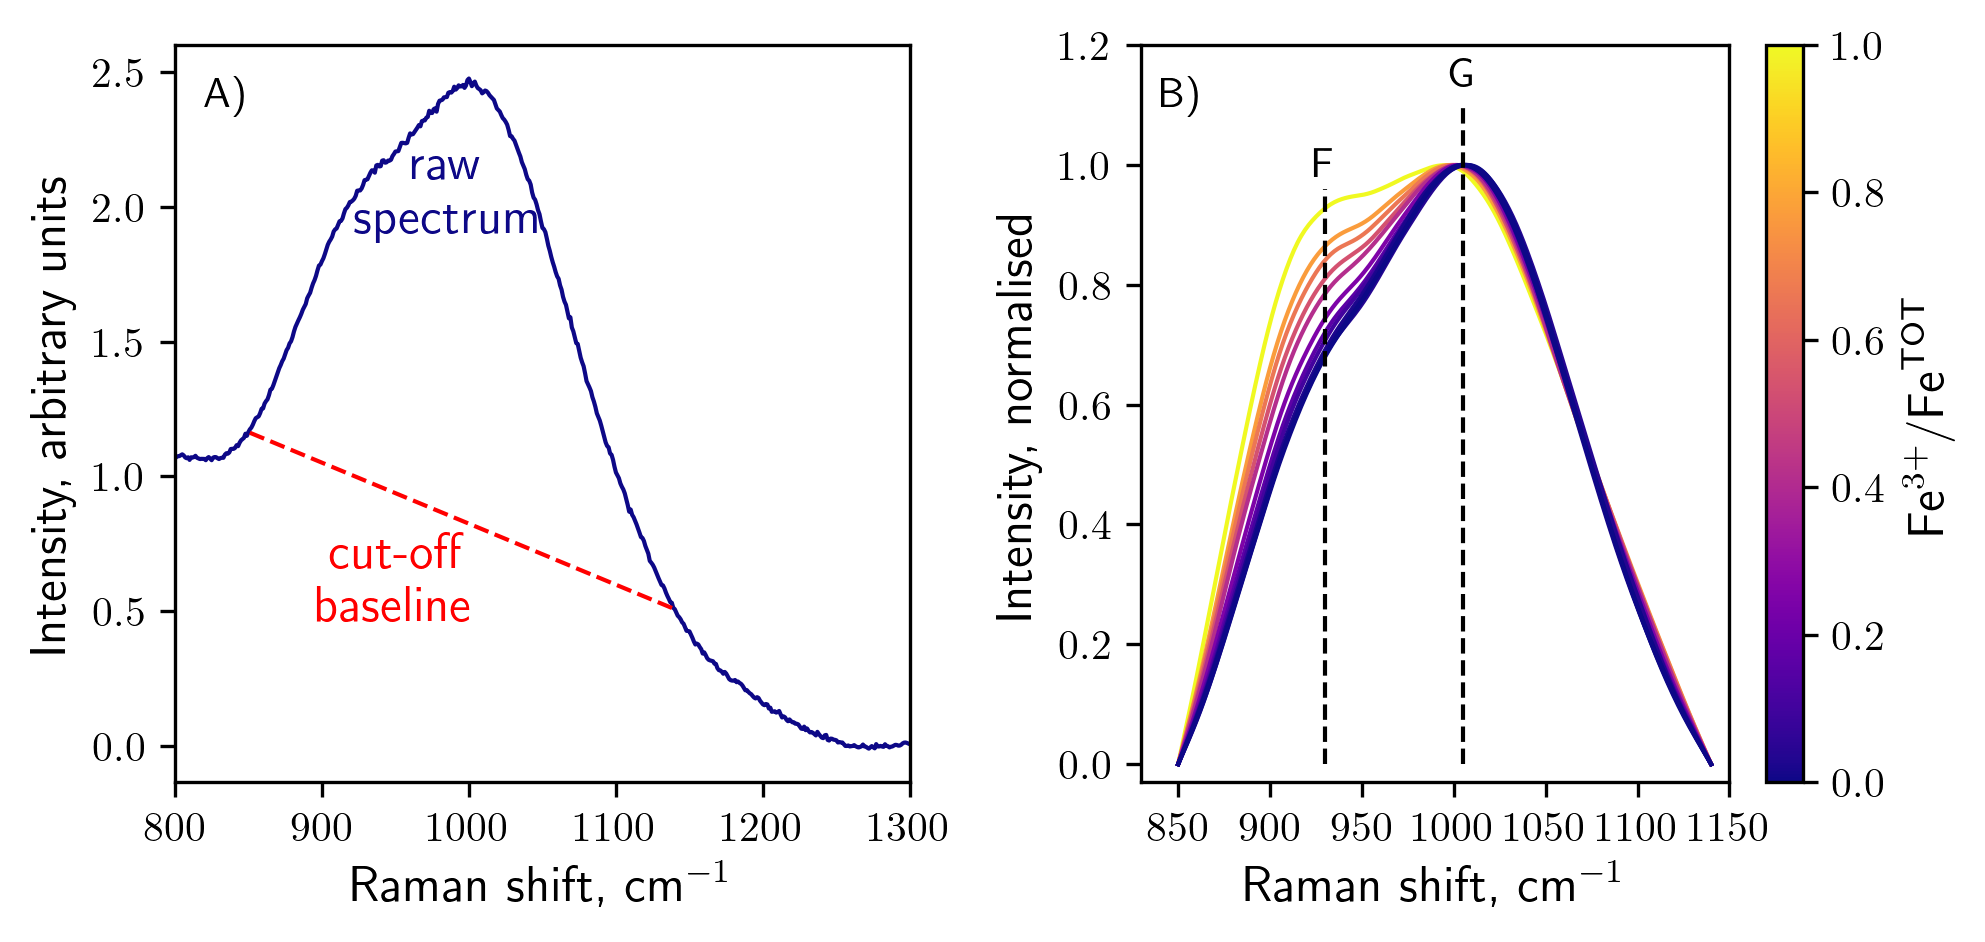

In [4]:
# Figure 2
fig2 = plt.figure(figsize=(6.73,3.24),dpi=300)

plt.subplot(1,2,1)
plt.plot(x,mean_record[:,12],"-",color=s_m.to_rgba(mean_fe3[12]))
plt.plot(x[(x>850)&(x<1140)],mean_bas2_std[(x>850)&(x<1140),12],"r--")
plt.xlim(800,1300)

plt.text(985,1.9,"raw\nspectrum",fontsize=12,rotation=0,color=s_m.to_rgba(mean_fe3[12]),ha="center")
plt.text(950,0.46,"cut-off\nbaseline",fontsize=12,rotation=0,color="red",ha="center")

plt.annotate("A)",xy=(0.07,0.93),xycoords='axes fraction',ha='center',va='center')
plt.xlabel(r"Raman shift, cm$^{-1}$"); plt.ylabel("Intensity, arbitrary units")

plt.subplot(1,2,2)

# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm
for i in range(mean_fe3.shape[0]):
    plt.plot(x_fit,
             mean_y_fit[:,i],
             color=s_m.to_rgba(mean_fe3[i]))

# having plotted the 11 curves we plot the colorbar, using again our
# ScalarMappable
c_bar = fig2.colorbar(s_m)
c_bar.set_label(r"Fe$^{3+}$/Fe\textsuperscript{TOT}")

plt.xticks([850,900,950,1000,1050,1100,1150])
plt.xlim(830,1150)
plt.ylim(-0.03,1.2)

plt.plot([930,930],[0.,0.96],"k--")
plt.plot([1005,1005],[0.,1.1],"k--")

plt.annotate("F",xy=(930,0.98),color="black",ha="center",xycoords="data")
plt.annotate("G",xy=(1005,1.13),color="black",ha="center",xycoords="data")

plt.annotate("B)",xy=(0.07,0.93),xycoords='axes fraction',ha='center',va='center')
plt.xlabel(r"Raman shift, cm$^{-1}$"); plt.ylabel("Intensity, normalised")

plt.tight_layout()
plt.savefig("./figures/Figure2.pdf")

# Additional figure: comparison of smoothed and unsmoothed data

Smoothing with the Whittaker filter removes a good amount of noise. The lambda parameter is set to 10^3, it is appropriate for the present data.

See in reference list Eilers et al. (2003) for details on the algorithm as well as the documentation of Rampy.

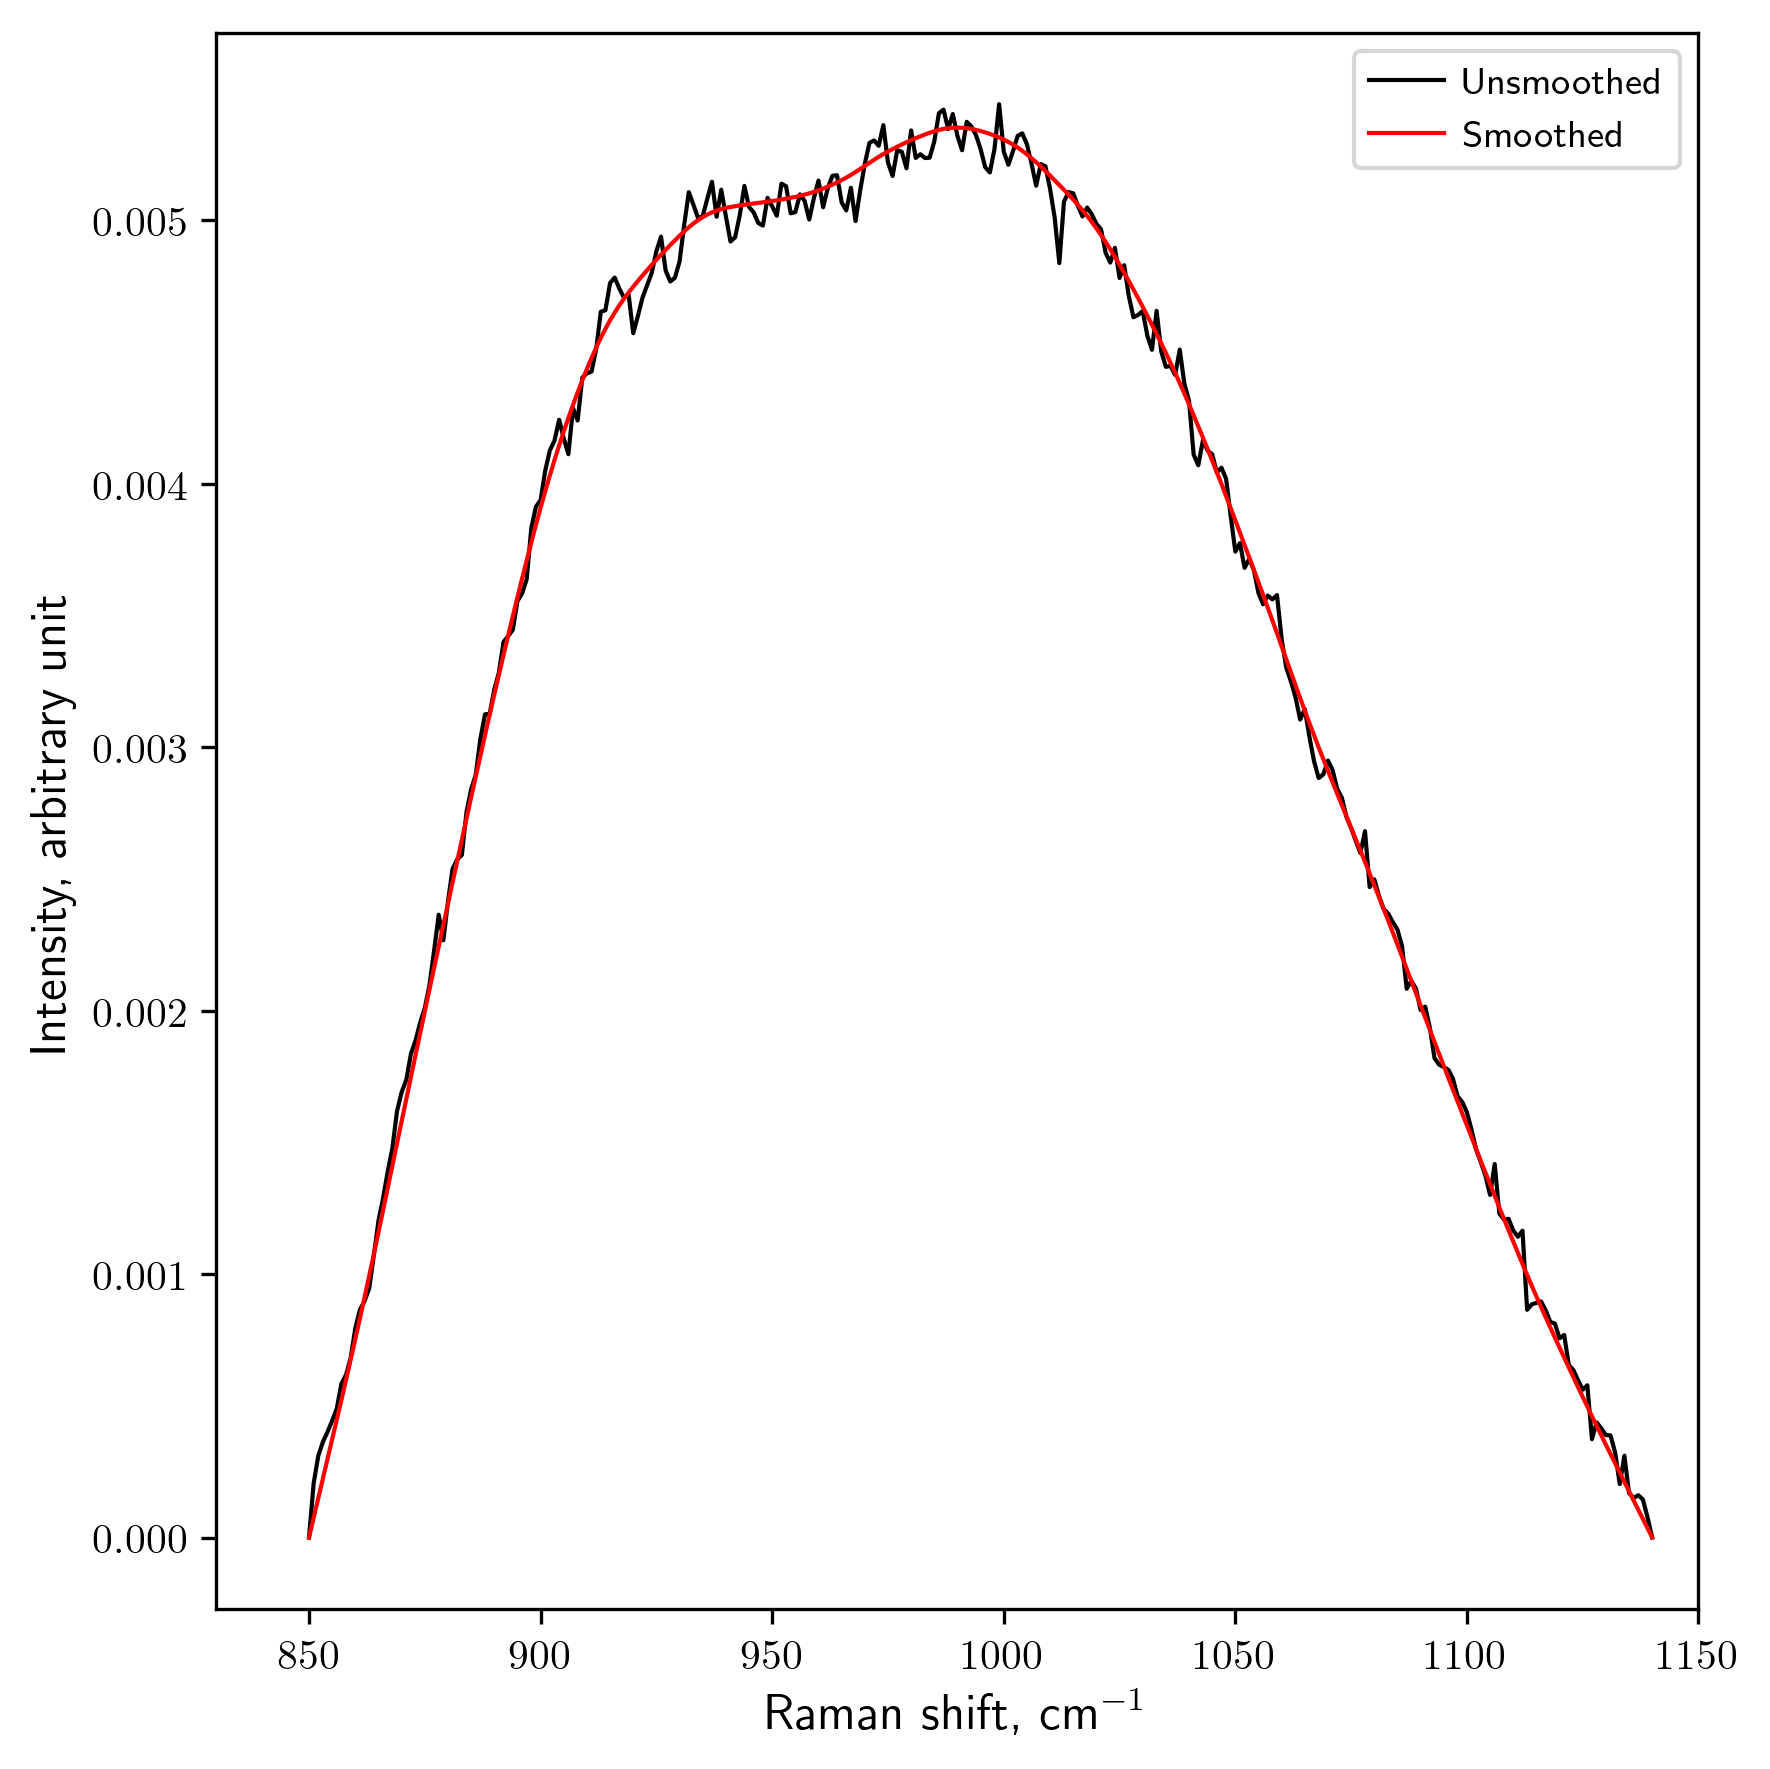

In [5]:
plt.figure(figsize=(6,6),dpi=300)

plt.plot(x_fit, y_fit_nosmo[:,0]/np.trapz(y_fit_nosmo[:,0],x_fit[:,0]),"k-",label="Unsmoothed")
plt.plot(x_fit, y_fit[:,0]/np.trapz(y_fit[:,0],x_fit[:,0]),"r-",label="Smoothed")

plt.xlim(830,1150)

plt.legend()

plt.ylabel("Intensity, arbitrary unit")
plt.xlabel(r"Raman shift, cm$^{-1}$")
plt.tight_layout()

# Figure 3: Intensity Method


Correlation coefficient between I930 and glass Fe3+/FeTOT is equal to 0.997290

The parameters of the calibration Fe3+/FeTOT = K1 + K2*I930 are:
(-2.779361803008743+/-0.028839888397397047, 4.083868296762201+/-0.03795735799717153)

The intensity ratio method has a rmse of 0.02


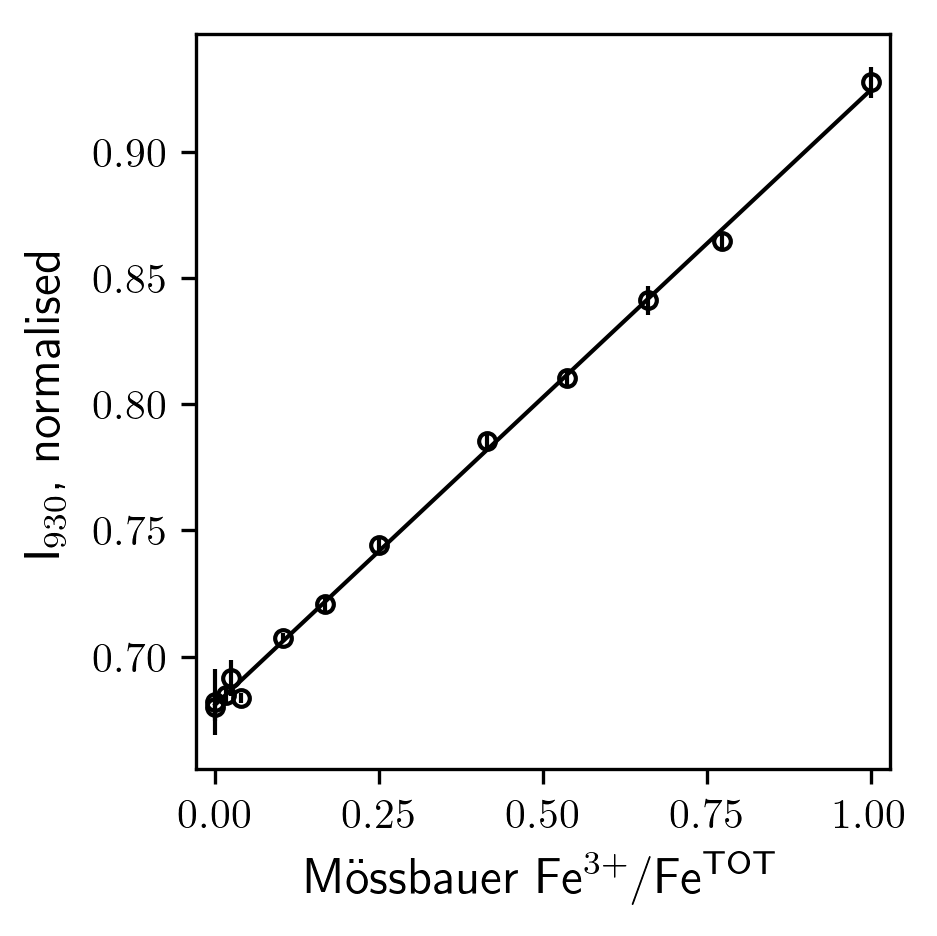

In [6]:
# Fig 3
I930_std = iron.intensity(x_fit,y_fit,idx1=929.0, idx2=931.0)
print("")
print("Correlation coefficient between I930 and glass Fe3+/FeTOT is equal to %f" % np.corrcoef(I930_std,fe3_standards)[0,1])

popt_I, pcov_I = op.curve_fit(rp.linear,I930_std,fe3_standards)# least square fit using the rp.linear function
params_I = uncertainties.correlated_values(popt_I, pcov_I)# package fitted parameters with their uncertainties

print("")
print("The parameters of the calibration Fe3+/FeTOT = K1 + K2*I930 are:")
print(params_I)

calibration_I = rp.linear(I930_std,*params_I)

# values for the reverse fit: line on plot
popt_lf, pcov_lf = op.curve_fit(rp.linear,fe3_standards,I930_std)
params_lf = uncertainties.correlated_values(popt_lf, pcov_lf)
linear_fit = rp.linear(fe3_standards,*params_lf)

plt.figure(figsize=(3.22,3.22),dpi=300)

intensity_results = np.zeros((int(nb_exp/5),3)) # intensity and ese values in columns 0 and 1, mean_fe in 3
counter = 0
for i in range(0,nb_exp,5):
    intensity_results[counter,0] = np.mean(I930_std[i:i+5])
    intensity_results[counter,1] = np.std(I930_std[i:i+5],ddof=1)
    intensity_results[counter,2] = np.mean(un.nominal_values(calibration_I)[i:i+5])
    counter = counter+1

plt.errorbar(mean_fe3,intensity_results[:,0],yerr=intensity_results[:,1],fmt=".",mfc="none",mec="black",color="black")

plt.plot(fe3_standards,un.nominal_values(linear_fit),"-",color="k")

plt.xlabel(r"M\"ossbauer Fe$^{3+}$/Fe\textsuperscript{TOT}")
plt.ylabel(r"I$_{930}$, normalised")
plt.xlim(-0.03,1.03)
plt.tight_layout()
plt.savefig("./figures/Figure3.pdf")

rmse_int = np.sqrt(mean_squared_error(un.nominal_values(calibration_I), fe3_standards))
print("")
print("The intensity ratio method has a rmse of %s" % str(round(rmse_int,2)))

# Figure 4: Mixing Method


Correlation coefficient between Fox and glass Fe3+/FeTOT is equal to 0.997460


The linear regression Fe3+/FeTOT = K1 + K2*FOX have parameters:
(0.003032129766068037+/-0.003997914739459689, 1.022915282027824+/-0.009203827250711028)


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


root-mean-square error between Fox as a proxy of Fe3+/Fetot and measured Fe3/Fetot = 0.03


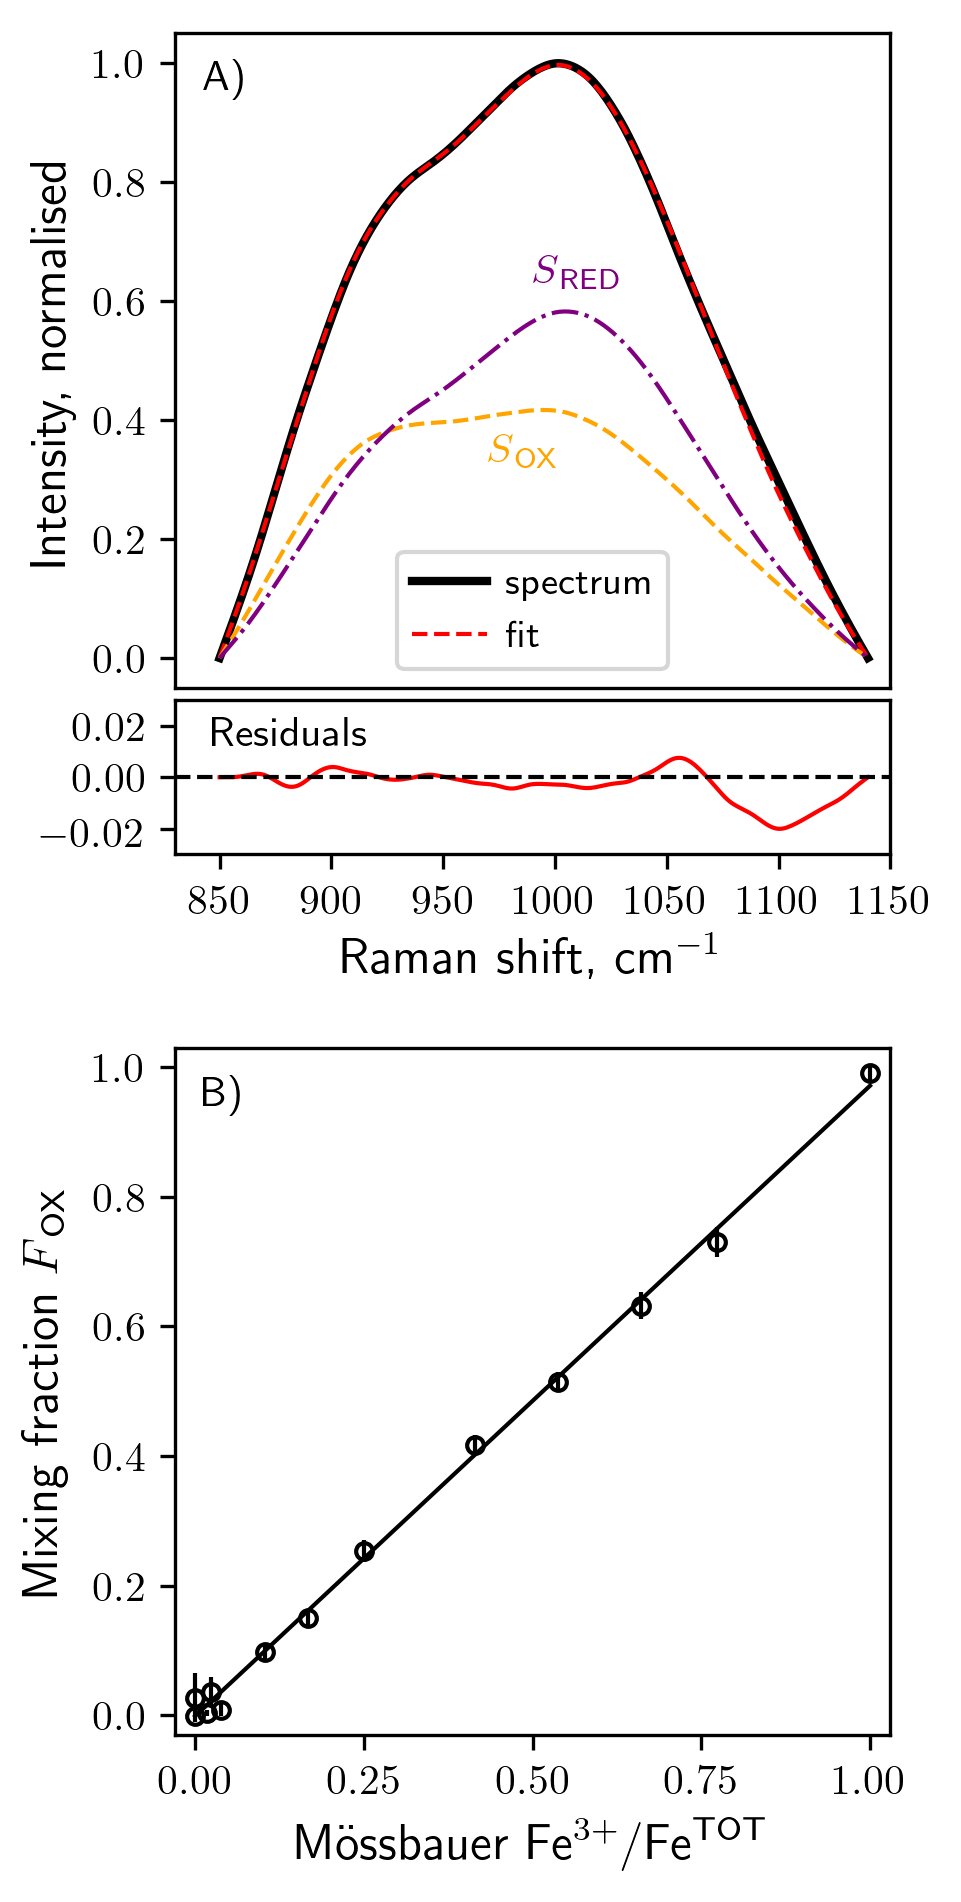

In [7]:
# On the entire dataset, we take the mean first and last spectra (Fe3+/FeTOT = 1 and 0, respectively) as references
oxy_ref = np.transpose(mean_y_fit[:,0])
red_ref = np.transpose(mean_y_fit[:,-1])

Fox = rp.mixing_sp(y_fit,oxy_ref,red_ref)
print("")
print("Correlation coefficient between Fox and glass Fe3+/FeTOT is equal to %f" % np.corrcoef(Fox,fe3_standards)[0,1])
print("")

# Calculating the average value for the 5 datapoints per sample
counter = 0
Fox_results = np.zeros((int(nb_exp/5),2))
for i in range(0,nb_exp,5):
    Fox_results[counter,0] = np.mean(Fox[i:i+5])
    Fox_results[counter,1] = np.std(Fox[i:i+5],ddof=1)
    counter = counter+1

#
# Linear regression
#
popt_M, pcov_M = op.curve_fit(rp.linear,Fox,fe3_standards,sigma = np.ones(len(Fox))*0.01)# least square fit using the rp.linear function
params_M = uncertainties.correlated_values(popt_M, pcov_M)# package fitted parameters with their uncertainties

print("")
print("The linear regression Fe3+/FeTOT = K1 + K2*FOX have parameters:")
print(params_M)

calibration_M = rp.linear(Fox,*params_M)

# values for the reverse fit: line on plot
popt_lfm, pcov_lfm = op.curve_fit(rp.linear,fe3_standards,Fox)
params_lfm = uncertainties.correlated_values(popt_lfm, pcov_lfm)
linear_fit_M = rp.linear(fe3_standards,*params_lfm)
    
#
# Making figure 4
#
   
plt.close('all')
fig = plt.figure(figsize=(3.22,6.44),dpi=300)

gs1 = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs1[0:-1])
ax2 = fig.add_subplot(gs1[-1])

gs2 = gridspec.GridSpec(1, 1)
ax3 = fig.add_subplot(gs2[:,:])

# ticks
ax1.set_xticks([])
ax2.set_xticks([850,900,950,1000,1050,1100,1150])
ax2.set_yticks([-0.02,0,0.02])

# limits
ax1.set_xlim(830,1150)
ax2.set_xlim(830,1150)
ax2.set_ylim(-0.03,0.03)
ax3.set_xlim(-0.03,1.03)
ax3.set_ylim(-0.03,1.03)

# label names
ax1.set_ylabel("Intensity, normalised")
ax2.set_xlabel(r"Raman shift, cm$^{-1}$")
ax3.set_xlabel(r"M\"ossbauer Fe$^{3+}$/Fe\textsuperscript{TOT}")
ax3.set_ylabel(r"Mixing fraction $F\textsubscript{OX}$")

#
# plotting
#

l1, = ax1.plot(x_fit,mean_y_fit[:,4],"k-",linewidth=2.0,label=r"spectrum")
l2, = ax1.plot(x_fit,Fox_results[4,0]*oxy_ref+(1-Fox_results[4,0])*red_ref,"r--",label="fit")
ax1.plot(x_fit,Fox_results[4,0]*oxy_ref,"--",color='orange')
ax1.plot(x_fit,(1-Fox_results[4,0])*red_ref,"-.",color="purple",label=r"D\textsubscript{Fe$^{3+}$/Fe\textsuperscript{TOT} = 0")

ax2.plot(x_fit,Fox_results[4,0]*oxy_ref+(1-Fox_results[4,0])*red_ref-mean_y_fit[:,4] - 0.0,"r-",label="residuals")
ax2.plot([830,1300],[0,0],"k--")

ax3.errorbar(mean_fe3, Fox_results[:,0],yerr=Fox_results[:,1],fmt=".",mfc="none",mec="black",color="black")
ax3.plot(fe3_standards,un.nominal_values(linear_fit_M),"-",color="k")

# legend
ax1.legend(handles=[l1,l2],loc='best')

# annotations
ax1.annotate("A)",xy=(0.07,0.93),xycoords='axes fraction',ha="center",va="center")
ax2.annotate("Residuals",xy=(0.05,0.7),xycoords='axes fraction')
ax3.annotate("B)",xy=(0.07,0.93),xycoords='axes fraction',ha="center",va="center")
ax1.annotate(r"$S\textsubscript{OX}$",xy=(970,0.32),color="orange")
ax1.annotate(r"$S\textsubscript{RED}$",xy=(990,0.62),color="purple")

# Final adjustment of the grid for nice output
gs1.tight_layout(fig,h_pad=0.1,rect=[0.,0.5,1,1])
gs2.tight_layout(fig,rect=[0.,0,1,0.5])

gs1.update(bottom=0.55)
gs2.update(top=0.45)

left = min(gs1.left, gs2.left)
right = max(gs1.right, gs2.right)

gs1.update(left=left, right=right)
gs2.update(left=left, right=right)

fig.savefig("./figures/Figure4.pdf") # saving

rmse_mixing_std = np.sqrt(mean_squared_error(Fox, fe3_standards))
print("root-mean-square error between Fox as a proxy of Fe3+/Fetot and measured Fe3/Fetot = %s" % str(round(rmse_mixing_std,2)))

# ALS MCR: Figures 5 and 6

Alternative Least Square Multivariate Curve Resolution

The ALS - MCR analysis was performed using the PyMCR package in Python.

This allowed to estimate endmember spectra, which then can be mixed with the mixing_sp() function to match new observations.

Tests of the effect of the dataset size and Fe$^{3+}$/Fe$^{TOT}$ span are performed, as well as of how the choice of starting components can affect results. See article for details.

In [8]:
# test of the dataset Fe3+/FeTOT span and mean value in a loop
mcr_err_D_ = np.zeros((len(mean_fe3),len(mean_fe3)))
dD = np.zeros((len(mean_fe3),len(mean_fe3))) #delta
mD = np.zeros((len(mean_fe3),len(mean_fe3))) #mean

for i in range(0,len(mean_fe3)):
    for j in range (0,len(mean_fe3)):

        if (i < j):
            D_ = y_fit[:,(fe3_standards<=mean_fe3[i])&(fe3_standards>= mean_fe3[j])]
            dD[i,j] = np.abs(mean_fe3[i]-mean_fe3[j])
            mD[i,j] = np.mean(fe3_standards[(fe3_standards<=mean_fe3[i])&(fe3_standards>= mean_fe3[j])])

            mcrals_ = McrAls(max_iter=50,c_constraints=[ConstraintNonneg(), ConstraintNorm()])
            mcrals_.fit(D_.T,ST=D_[:,(0,-1)].T,verbose=False)

            conc_als_ = rp.mixing_sp(y_fit,mcrals_.ST_opt_[0,:],mcrals_.ST_opt_[1,:])
            
            mcr_err_D_[i,j]=np.sqrt(mean_squared_error(conc_als_, fe3_standards))
                

In [9]:
# test of the effect of the starting S components on final rmse in a loop
mcr_err_S_ = np.zeros((len(mean_fe3),len(mean_fe3)))
dS = np.zeros((len(mean_fe3),len(mean_fe3))) #delta
mS = np.zeros((len(mean_fe3),len(mean_fe3))) #mean

for i in range(0,len(mean_fe3)):
    for j in range (0,len(mean_fe3)):

        if (i < j):
            dS[i,j] = np.abs(mean_fe3[i]-mean_fe3[j])
            mS[i,j] = (mean_fe3[i]+mean_fe3[j])/2

            mcrals_ = McrAls(max_iter=50,c_constraints=[ConstraintNonneg(), ConstraintNorm()])
            mcrals_.fit(y_fit.T,ST=mean_y_fit[:,(i,j)].T,verbose=False)            
            
            if mcrals_.C_opt_[0,0] > mcrals_.C_opt_[0,1]: 
                mcr_err_S_[i,j]=np.sqrt(mean_squared_error(mcrals_.C_opt_[:,0], fe3_standards))
            else:
                mcr_err_S_[i,j]=np.sqrt(mean_squared_error(mcrals_.C_opt_[:,1], fe3_standards))
                  

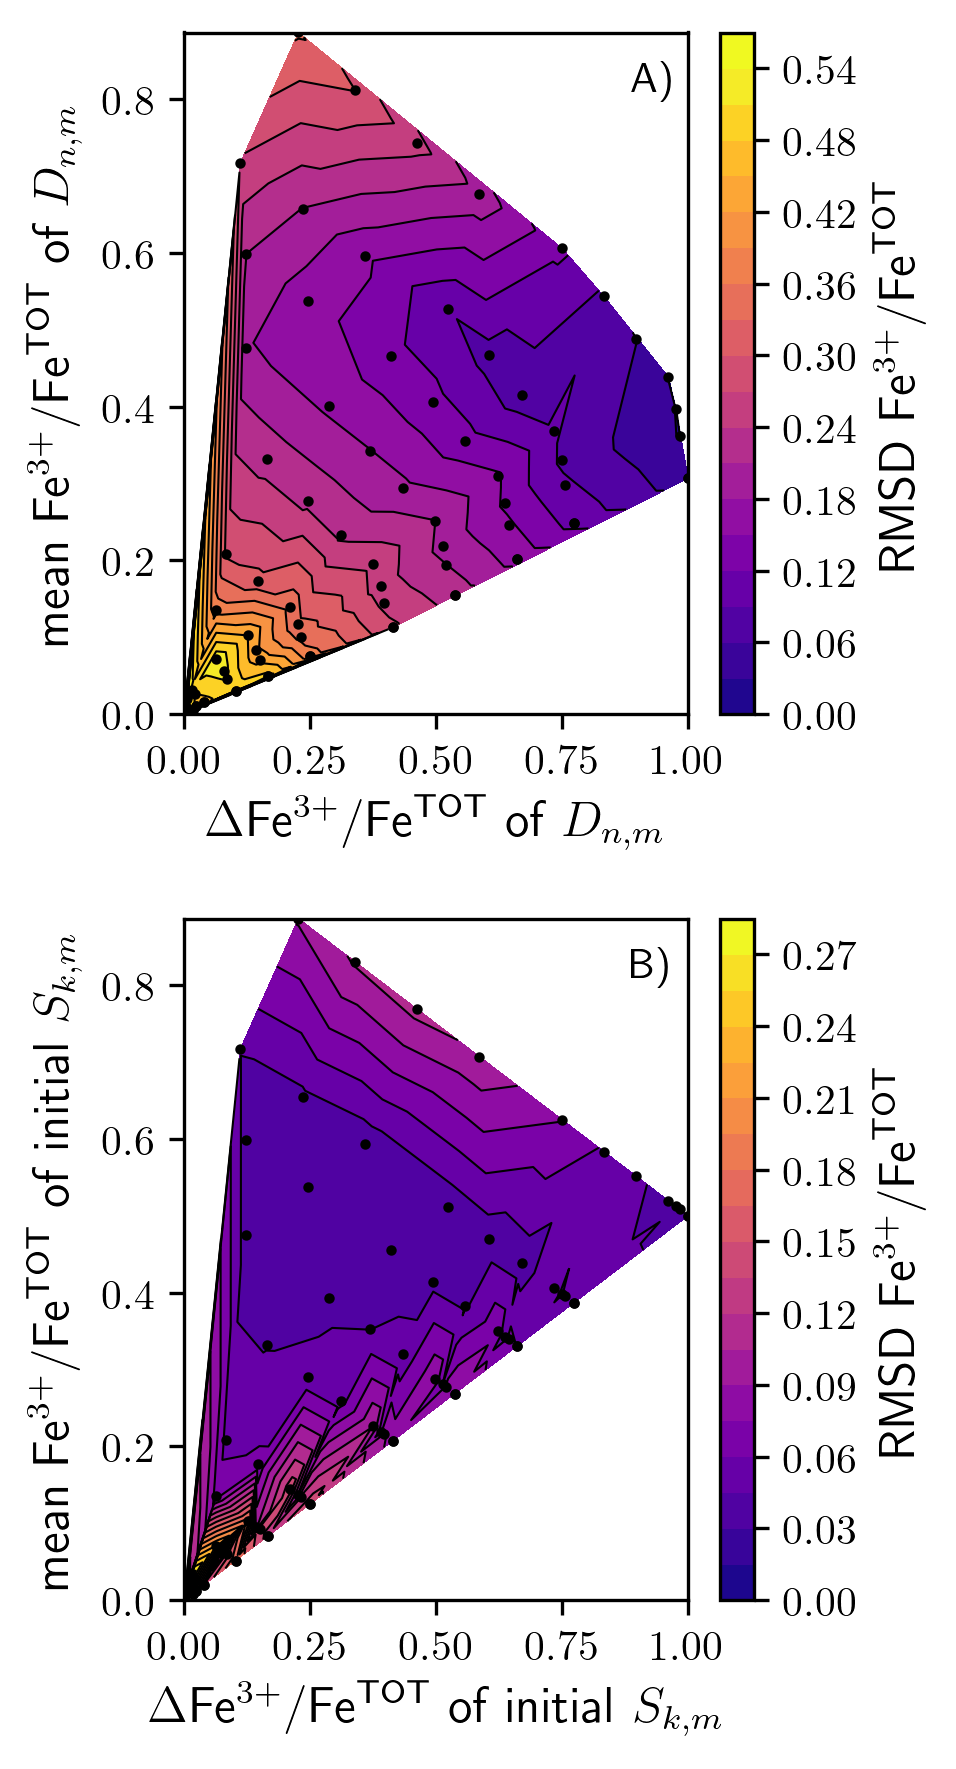

In [10]:
# Figure 5 : results
from matplotlib.mlab import griddata
import matplotlib.tri as tri

# Trying tricontour
plt.figure(figsize=(3.22,6),dpi=300)

plt.subplot(2,1,1)
plt.tricontour(dD.flatten(), mD.flatten(), mcr_err_D_.flatten(), 20, linewidths=0.5, colors='k') # contour lines
plt.tricontourf(dD.flatten(), mD.flatten(), mcr_err_D_.flatten(), 20, # color map plot/parameters
                    cmap = matplotlib.cm.plasma,
                    norm=plt.Normalize(vmax=np.max(mcr_err_D_), vmin=np.min(mcr_err_D_))) #abs(Ir).min()
cbar1 = plt.colorbar()  # draw colorbar
cbar1.ax.set_ylabel(r'RMSD Fe$^{3+}$/Fe\textsuperscript{TOT}')

plt.xlabel(r"$\Delta$Fe$^{3+}$/Fe\textsuperscript{TOT} of $D_{n,m}$")
plt.ylabel(r"mean Fe$^{3+}$/Fe\textsuperscript{TOT} of $D_{n,m}$")

plt.plot(dD.flatten(), mD.flatten(), 'k.', ms=3)

plt.annotate("A)",xy=(0.93,0.93),ha="center",va="center",xycoords="axes fraction")

plt.subplot(2,1,2)
plt.tricontour(dS.flatten(), mS.flatten(), mcr_err_S_.flatten(), 20, linewidths=0.5, colors='k') # contour lines
plt.tricontourf(dS.flatten(), mS.flatten(), mcr_err_S_.flatten(), 20, # color map plot/parameters
                    cmap = matplotlib.cm.plasma,
                    norm=plt.Normalize(vmax=np.max(mcr_err_S_), vmin=np.min(mcr_err_S_))) #abs(Ir).min()
cbar2 = plt.colorbar()  # draw colorbar
cbar2.ax.set_ylabel(r'RMSD Fe$^{3+}$/Fe\textsuperscript{TOT}')

plt.plot(dS.flatten(), mS.flatten(), 'k.', ms=3)

plt.xlabel(r"$\Delta$Fe$^{3+}$/Fe\textsuperscript{TOT} of initial $S_{k,m}$")
plt.ylabel(r"mean Fe$^{3+}$/Fe\textsuperscript{TOT} of initial $S_{k,m}$")

plt.annotate("B)",xy=(0.93,0.93),ha="center",va="center",xycoords="axes fraction")

plt.tight_layout()
plt.savefig("./figures/Figure5.pdf")

# Figure 6: optimal ALS-MCR fit


Final MSE: 3.5921631e-05
Optimal Iteration: 1.1000000e+01

The linear regression Fe3+/FeTOT = K1 + K2*Cox for ALS MCR have parameters:
(-0.03275635336850913+/-0.004639772455584165, 1.0643983013523568+/-0.010521340213413182)
RMSE with using starting spectra at 0.66 and 0.25 is 0.03
If we assume Cox directly equals Fe3+/FeTOT, rmse is 0.03


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/gridspec.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


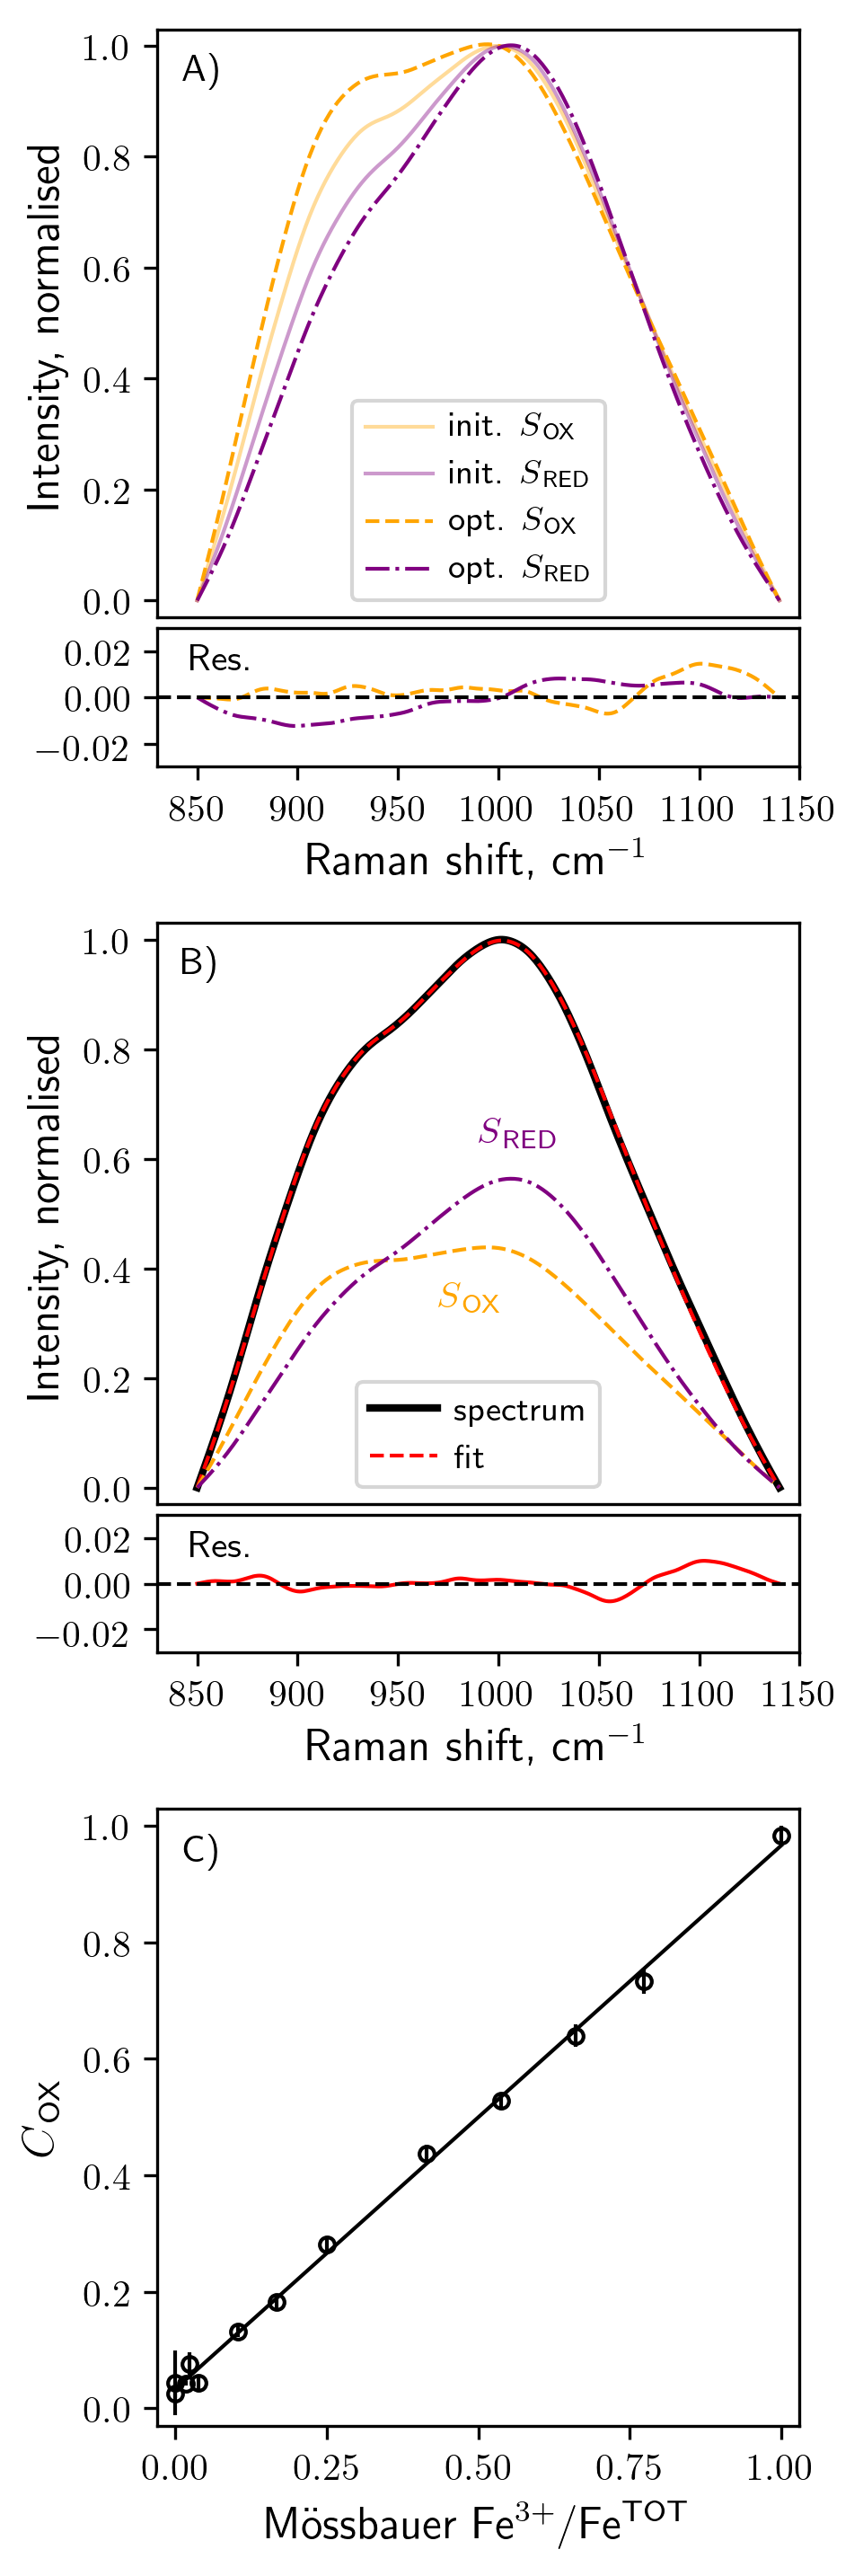

In [11]:
#
# Doing the fit with mean spectra at 0.66 (2) and 0.25 (5) as starting S values (index 0 and -1)
#
mcrals = McrAls(max_iter=50,c_constraints=[ConstraintNonneg(), ConstraintNorm()])
mcrals.fit(y_fit.T,ST=mean_y_fit[:,(2,5)].T)

print('\nFinal MSE: {:.7e}'.format(mcrals.err[-1]))
print('Optimal Iteration: {:.7e}'.format(mcrals.n_iter_opt))

# we mix the optimised extrema
conc_als_mcr = rp.mixing_sp(y_fit,mcrals.ST_opt_[0,:],mcrals.ST_opt_[1,:])

#
# Linear regression
#

popt_MCR, pcov_MCR = op.curve_fit(rp.linear,conc_als_mcr,fe3_standards)# least square fit using the rp.linear function
params_MCR = uncertainties.correlated_values(popt_MCR, pcov_MCR)# package fitted parameters with their uncertainties

print("")
print("The linear regression Fe3+/FeTOT = K1 + K2*Cox for ALS MCR have parameters:")
print(params_MCR)

calibration_MCR = rp.linear(conc_als_mcr,*params_MCR) # good MCR fractions

# for the plot: reverse fit 
popt_lfmcr, pcov_lfmcr = op.curve_fit(rp.linear,fe3_standards,conc_als_mcr)
params_lfmcr = uncertainties.correlated_values(popt_lfmcr, pcov_lfmcr)
linear_fit_MCR = rp.linear(fe3_standards,*params_lfmcr)

mse_als = np.sqrt(mean_squared_error(un.nominal_values(calibration_MCR), fe3_standards))
print('RMSE with using starting spectra at 0.66 and 0.25 is %.2f' % mse_als)

print('If we assume Cox directly equals Fe3+/FeTOT, rmse is %.2f' % np.sqrt(mean_squared_error(conc_als_mcr, fe3_standards)))

#
# calculating mean values for errorbar plot
#

conc_als_mcr_mean = np.zeros((len(mean_fe3),3)) # mean value, std, and associated mean Fe3
counter = 0
for i in range(0,nb_exp,5):
    conc_als_mcr_mean[counter,0]=np.mean(conc_als_mcr[i:i+5])
    conc_als_mcr_mean[counter,1]=np.std(conc_als_mcr[i:i+5],ddof=1)
    conc_als_mcr_mean[counter,2]=np.mean(un.nominal_values(calibration_MCR)[i:i+5])
    counter += 1
#    
# FIGURE 6
#

fig6 = plt.figure(figsize=(3.22,9.66),dpi=300)

#
# Preparing layout
#

plt_height = 0.24

gs1m = GridSpec(5, 1)
ax1_mcr = fig6.add_subplot(gs1m[0:-1, 0])
ax5_mcr = fig6.add_subplot(gs1m[-1, 0])

gs2m = GridSpec(5, 1)
ax2_mcr = fig6.add_subplot(gs2m[0:-1, 0])
ax3_mcr = fig6.add_subplot(gs2m[-1, 0])

gs3m = GridSpec(1, 1)
ax4_mcr = fig6.add_subplot(gs3m[0, 0])

#
# PLOTS
#

# those were the starting spectra
ax1_mcr.plot(x_fit,mean_y_fit[:,2],"-",color='orange',alpha=0.4,label=r'init. $S$\textsubscript{OX}')
ax1_mcr.plot(x_fit,mean_y_fit[:,5],"-",color='purple',alpha=0.4,label=r'init. $S$\textsubscript{RED}')

# those are the optimised spectra
ax1_mcr.plot(x_fit,mcrals.ST_opt_[0,:],"--",color='orange',label=r'opt. $S$\textsubscript{OX}')
ax1_mcr.plot(x_fit,mcrals.ST_opt_[1,:],"-.",color='purple',label=r'opt. $S$\textsubscript{RED}')

# the fits
ax2_mcr.plot(x_fit,mean_y_fit[:,4],"k-",linewidth=2.0,label=r"spectrum")
ax2_mcr.plot(x_fit,conc_als_mcr_mean[4,0]*mcrals.ST_opt_[0,:]+(1-conc_als_mcr_mean[4,0])*mcrals.ST_opt_[1,:],"r--",label="fit")
ax2_mcr.plot(x_fit,conc_als_mcr_mean[4,0]*mcrals.ST_opt_[0,:],"--",color="orange")
ax2_mcr.plot(x_fit,(1-conc_als_mcr_mean[4,0])*mcrals.ST_opt_[1,:],"-.",color="purple")

ax3_mcr.plot(x_fit,mean_y_fit[:,4]-(conc_als_mcr_mean[4,0]*mcrals.ST_opt_[0,:]+(1-conc_als_mcr_mean[4,0])*mcrals.ST_opt_[1,:]),"r-",label="fit")
ax3_mcr.plot([830,1300],[0,0],"k--")

# the iron comparison
ax4_mcr.plot(fe3_standards,un.nominal_values(linear_fit_MCR),"-",color="k")
ax4_mcr.errorbar(mean_fe3,conc_als_mcr_mean[:,0],yerr=conc_als_mcr_mean[:,1],fmt='.',mfc="none",mec="black",color="black")

# comparing the optimised spectra and those at Fe3+/FeTOT = 0 and 1
ax5_mcr.plot(x_fit,mcrals.ST_opt_[0,:]-mean_y_fit[:,0],"--",color='orange',label=r'opt. $S$\textsubscript{OX} - D\textsubscript{Fe$^{3+}$/Fe\textsuperscript{TOT} = 1}')
ax5_mcr.plot(x_fit,mcrals.ST_opt_[1,:]-mean_y_fit[:,-1],"-.",color='purple',label=r'opt. $S$\textsubscript{RED} - D\textsubscript{Fe$^{3+}$/Fe\textsuperscript{TOT} = 0}')
ax5_mcr.plot([830,1300],[0,0],"k--")

# Limits
ax1_mcr.set_xlim(830,1150)
ax2_mcr.set_xlim(830,1150)
ax3_mcr.set_xlim(830,1150)
ax4_mcr.set_xlim(-0.03,1.03)
ax5_mcr.set_xlim(830,1150)

ax1_mcr.set_ylim(-0.03,1.03)
ax2_mcr.set_ylim(-0.03,1.03)
ax3_mcr.set_ylim(-0.03,0.03)
ax4_mcr.set_ylim(-0.03,1.03)
ax5_mcr.set_ylim(-0.03,0.03)

# labels
ax3_mcr.set_xlabel(r"Raman shift, cm$^{-1}$")
ax4_mcr.set_xlabel(r"M\"ossbauer Fe$^{3+}$/Fe\textsuperscript{TOT}")
ax5_mcr.set_xlabel(r"Raman shift, cm$^{-1}$")

ax1_mcr.set_ylabel("Intensity, normalised")
ax2_mcr.set_ylabel("Intensity, normalised")
ax4_mcr.set_ylabel(r"$C\textsubscript{OX}$")

# annotations
ax1_mcr.annotate("A)",xy=(0.07,0.93),ha="center",va="center",xycoords="axes fraction")
ax2_mcr.annotate("B)",xy=(0.07,0.93),ha="center",va="center",xycoords="axes fraction")
ax2_mcr.annotate(r"$S\textsubscript{OX}$",xy=(970,0.32),color="orange")
ax2_mcr.annotate(r"$S\textsubscript{RED}$",xy=(990,0.62),color="purple")
ax3_mcr.annotate("Res.",xy=(0.05,0.7),xycoords="axes fraction")
ax4_mcr.annotate("C)",xy=(0.07,0.93),ha="center",va="center",xycoords="axes fraction")
ax5_mcr.annotate("Res.",xy=(0.05,0.7),xycoords="axes fraction")

# legend
ax1_mcr.legend(loc="best")
ax2_mcr.legend(loc="best")

# ticks
ax1_mcr.set_xticks([])
ax2_mcr.set_xticks([])
ax3_mcr.set_yticks([-0.02,0,0.02])
ax5_mcr.set_yticks([-0.02,0,0.02])
ax5_mcr.set_xticks([850,900,950,1000,1050,1100,1150])
ax3_mcr.set_xticks([850,900,950,1000,1050,1100,1150])

# Final adjustment of the grid for nice output
gs1m.tight_layout(fig6,w_pad=0.,h_pad=0.1,rect=[0,0.66,1,1.])
gs2m.tight_layout(fig6,w_pad=0.,h_pad=0.1,rect=[0,0.33,1,.66])
gs3m.tight_layout(fig6,w_pad=0.,rect=[0,0.,1,.33])

gs1m.update(bottom=0.70)
gs2m.update(bottom=0.36,top=0.64)
gs3m.update(top=0.30)

left = min(gs1m.left, gs2m.left, gs3m.left)
right = max(gs1m.right, gs2m.right, gs3m.right)

gs1m.update(left=left, right=right)
gs2m.update(left=left, right=right)
gs3m.update(left=left, right=right)

fig6.savefig("./figures/Figure6.pdf")

# Supervised Machine Learning Methods

In [12]:
#
# TRAIN-TEST SPLIT
#
train_sub, test_sub, idxtrain_sub, idxtest_sub = rp.chemical_splitting(liste_standards,'logfo2',0.35)
y_train = fe3_standards.iloc[idxtrain_sub[0]]
X_train = y_fit[:,idxtrain_sub[0]]

y_test = fe3_standards.iloc[idxtest_sub[0]]
X_test = y_fit[:,idxtest_sub[0]]

# we need to put X_test and X_train with rows = samples and columns = frequencies
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

print("Testing data subset represents %.1f percents of the dataset." % (float(len(y_test))/float(len(fe3_standards))*100))

#
# TRAINING
#
#
# Gridsearch of hyperparameters for kernel ridge and support vector regression
#
prm_kr =  dict(alpha=[1e2, 1e3, 1e1, 1e0, 0.5, 0.1, 5e-2, 1e-2, 5e-3, 1e-3],gamma=np.logspace(-6, 6, 13))
prm_svr =  dict(C=[1e0, 2e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5],gamma=np.logspace(-6, 6, 13))

#
# parameters for neural net
#

# 3 relu activation units, solver lbfgs, early stopping on
prm_nn = dict(hidden_layer_sizes=(3,),solver = 'lbfgs',activation='relu',early_stopping=True)

# bagging 100 networks, with bootstrap on, random state 42 and on 1 core.
prm_bag = dict(n_estimators=100, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=42, verbose=0)


# model objects
nn_mod =  rp.mlregressor(X_train,y_train.values,X_test=X_test, y_test = y_test.values,algorithm="BaggingNeuralNet",scaler="StandardScaler")
svr_mod = rp.mlregressor(X_train,y_train.values,X_test=X_test, y_test = y_test.values,algorithm="SVM",scaler="StandardScaler")
kr_mod =  rp.mlregressor(X_train,y_train.values,X_test=X_test, y_test = y_test.values,algorithm="KernelRidge",scaler="StandardScaler")

svr_mod.param_svm = prm_svr
kr_mod.param_kr = prm_kr
nn_mod.param_neurons = prm_nn
nn_mod.param_bag = prm_bag

nn_mod.fit()
kr_mod.fit()
svr_mod.fit()

Testing data subset represents 38.5 percents of the dataset.


In [13]:
#
# Calculating mean values for each sample, for the figure 6
#

y_train_mean = np.zeros((int(len(y_train)/5)))
y_test_mean = np.zeros((int(len(y_test)/5)))
kr_train_mean = np.zeros((int(len(y_train)/5),2))
kr_test_mean = np.zeros((int(len(y_test)/5),2))
svr_train_mean = np.zeros((int(len(y_train)/5),2))
svr_test_mean = np.zeros((int(len(y_test)/5),2))
nn_train_mean = np.zeros((int(len(y_train)/5),2))
nn_test_mean = np.zeros((int(len(y_test)/5),2))

# for the training subset
counter= 0 
for i in range(0,len(y_train),5):
    y_train_mean[counter] = np.mean(y_train[i:i+5])
    kr_train_mean[counter,0] = np.mean(kr_mod.prediction_train[i:i+5])
    svr_train_mean[counter,0] = np.mean(svr_mod.prediction_train[i:i+5])
    nn_train_mean[counter,0] = np.mean(nn_mod.prediction_train[i:i+5])

    kr_train_mean[counter,1] = np.std(kr_mod.prediction_train[i:i+5],ddof=1)
    svr_train_mean[counter,1] = np.std(svr_mod.prediction_train[i:i+5],ddof=1)
    nn_train_mean[counter,1] = np.std(nn_mod.prediction_train[i:i+5],ddof=1)
    counter += 1
    
# for testing set subset
counter = 0    
for i in range(0,len(y_test),5):
    y_test_mean[counter] = np.mean(y_test[i:i+5])
    kr_test_mean[counter,0] = np.mean(kr_mod.prediction_test[i:i+5])
    svr_test_mean[counter,0] = np.mean(svr_mod.prediction_test[i:i+5])
    nn_test_mean[counter,0] = np.mean(nn_mod.prediction_test[i:i+5])

    kr_test_mean[counter,1] = np.std(kr_mod.prediction_test[i:i+5],ddof=1)
    svr_test_mean[counter,1] = np.std(svr_mod.prediction_test[i:i+5],ddof=1)
    nn_test_mean[counter,1] = np.std(nn_mod.prediction_test[i:i+5],ddof=1)
    counter += 1
    
#
# Measuring errors on training and testing datasets
#

MSE_SVR_train = np.sqrt(mean_squared_error(y_train, svr_mod.prediction_train))
MSE_KR_train = np.sqrt(mean_squared_error(y_train, kr_mod.prediction_train))
MSE_NN_train = np.sqrt(mean_squared_error(y_train, nn_mod.prediction_train))

MSE_SVR_test = np.sqrt(mean_squared_error(y_test, svr_mod.prediction_test))
MSE_KR_test = np.sqrt(mean_squared_error(y_test, kr_mod.prediction_test))
MSE_NN_test = np.sqrt(mean_squared_error(y_test, nn_mod.prediction_test))

#
# returning values for the entire dataset
# we use the Yscaler, Xscaler and model_xx objects to predict new values
# those objects can be saved on the hard drive for futur estimations using joblib (see skleanr docs)
#
nn_all = nn_mod.predict(y_fit.T)
kr_all = kr_mod.predict(y_fit.T)
svr_all = svr_mod.predict(y_fit.T)

# calculating the mean for all samples
kr_all_mean = np.zeros(len(mean_fe3))
svr_all_mean = np.zeros(len(mean_fe3))
nn_all_mean = np.zeros(len(mean_fe3))
counter = 0    
for i in range(0,len(fe3_standards),5):
    kr_all_mean[counter] = np.mean(kr_all[i:i+5])
    svr_all_mean[counter] = np.mean(svr_all[i:i+5])
    nn_all_mean[counter] = np.mean(nn_all[i:i+5])

    counter += 1

#
# Printing
#

print("Training errors are:")
print("Support Vector: %.2f" % MSE_SVR_train)
print("Kernel Ridge: %.2f" % MSE_KR_train)
print("Neural Net: %.2f" % MSE_NN_train)

print("")
print("Testing errors are:")
print("Support Vector: %.2f" % MSE_SVR_test)
print("Kernel Ridge: %.2f" % MSE_KR_test)
print("Neural Net: %.2f" % MSE_NN_test)

Training errors are:
Support Vector: 0.02
Kernel Ridge: 0.01
Neural Net: 0.01

Testing errors are:
Support Vector: 0.03
Kernel Ridge: 0.02
Neural Net: 0.04


## Figure 7

Comparing the Fe$^{3+}$/Fe$^{TOT}$ calculated by supervised machine learning methods to those measured.

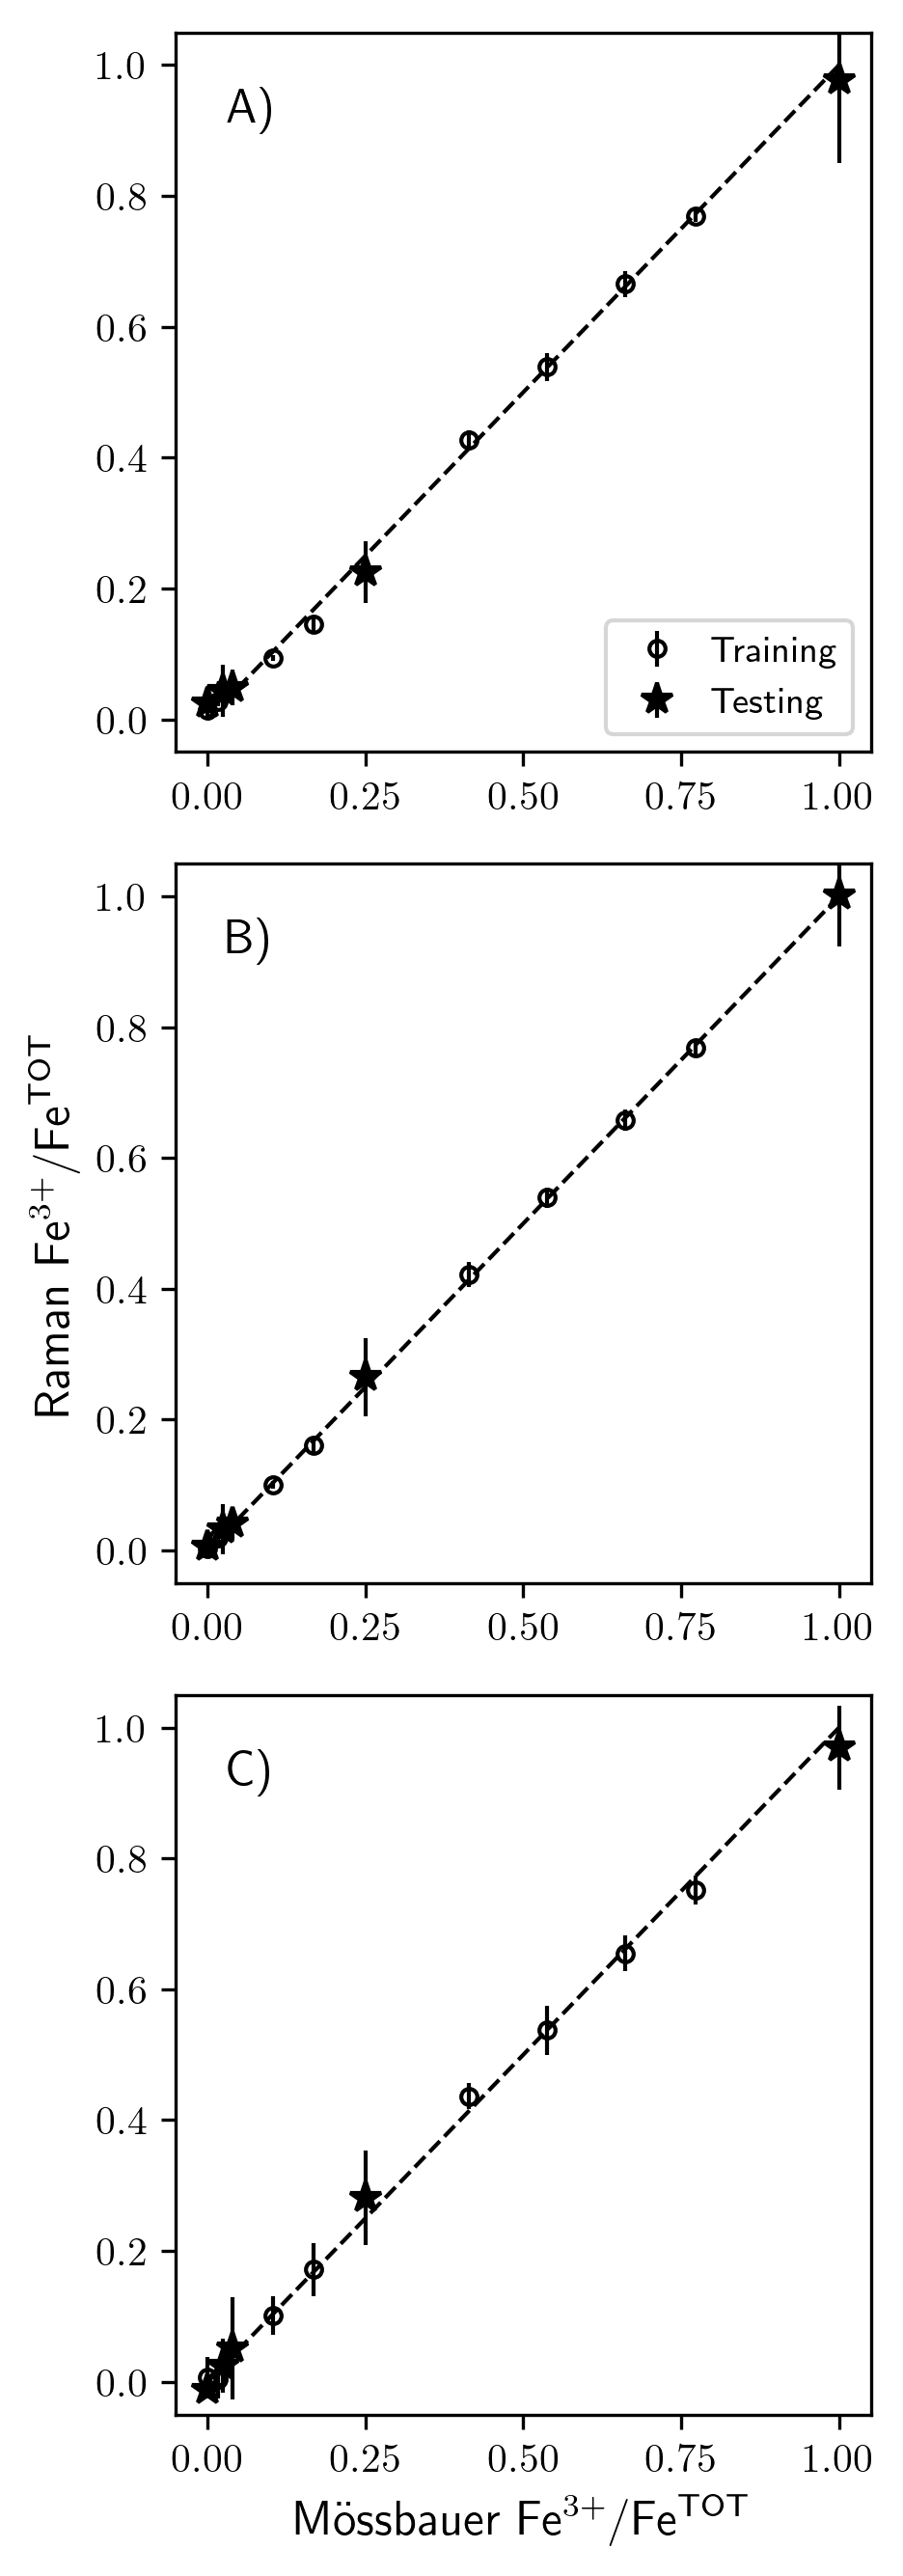

In [14]:
fig7 = plt.figure(figsize=(3.22,9),dpi=300)

# Neural Networks
plt.subplot(3,1,1)
plt.annotate("A)",xy=[0.07,0.93],ha="center",va="center",fontsize=12)
plt.errorbar(y_train_mean, nn_train_mean[:,0],yerr=2*nn_train_mean[:,1],fmt=".",mfc="none",mec="black",color="black",label="Training")
plt.errorbar(y_test_mean, nn_test_mean[:,0],yerr=2*nn_test_mean[:,1],fmt="*",mfc="black",mec="black",color="black",label="Testing")
plt.plot([0,1],[0,1],"k--")
plt.xlim(-0.05,1.05); plt.ylim(-0.05,1.05)
plt.legend(loc=4)

plt.subplot(3,1,2)

# Kernel Ridge
plt.annotate("B)",xy=[0.07,0.93],ha="center",va="center",fontsize=12)
plt.errorbar(y_train_mean, kr_train_mean[:,0],yerr=2*kr_train_mean[:,1],fmt=".",mfc="none",mec="black",color="black",label="Training")
plt.errorbar(y_test_mean, kr_test_mean[:,0],yerr=2*kr_test_mean[:,1],fmt="*",mfc="black",mec="black",color="black",label="Testing")
plt.plot([0,1],[0,1],"k--")
plt.xlim(-0.05,1.05); plt.ylim(-0.05,1.05)
plt.ylabel(r"Raman Fe$^{3+}$/Fe\textsuperscript{TOT}")

# Support Vector
plt.subplot(3,1,3)
plt.annotate("C)",xy=[0.07,0.93],ha="center",va="center",fontsize=12)
plt.errorbar(y_train_mean, svr_train_mean[:,0],yerr=2*svr_train_mean[:,1],fmt=".",mfc="none",mec="black",color="black",label="Training")
plt.errorbar(y_test_mean, svr_test_mean[:,0],yerr=2*svr_test_mean[:,1],fmt="*",mfc="black",mec="black",color="black",label="Testing")
plt.plot([0,1],[0,1],"k--")
plt.xlim(-0.05,1.05); plt.ylim(-0.05,1.05)
plt.xlabel(r"M\"ossbauer Fe$^{3+}$/Fe\textsuperscript{TOT}")

fig7.tight_layout()
fig7.savefig("./figures/Figure7.pdf")

# Printing errors for all techniques

In [15]:
MSE_tot = np.sqrt(mean_squared_error(np.mean(np.vstack((nn_all.T,kr_all.T,svr_all.T,un.nominal_values(calibration_MCR),un.nominal_values(calibration_I),Fox)).T,1),fe3_standards))

print("SUMMARY OF THE ERRORS")
print("")
print("RMSE for ALS MCR, Intensity ratio and Mixing methods:")
print("Intensity method: %f"%round(rmse_int,2))
print("Mixing method = %f"%round(rmse_mixing_std,2))
print("ALS MCR method: %f"%round(mse_als,2))
print("")
print("RMSE for supervised machine learning methods:")
print("")
print("TRAINING SUBSET")
print("NN method: %f"%round(MSE_NN_train,2))
print("KR method: %f"%round(MSE_KR_train,2))
print("SVR method: %f"%round(MSE_SVR_train,2))

print("")
print("TESTING SUBSET")
print("NN method: %f"%round(MSE_NN_test,2))
print("KR method: %f"%round(MSE_KR_test,2))
print("SVR method: %f"%round(MSE_SVR_test,2))
print("")

print("")
print("Global RMSE is %f"%round(MSE_tot,2))


SUMMARY OF THE ERRORS

RMSE for ALS MCR, Intensity ratio and Mixing methods:
Intensity method: 0.020000
Mixing method = 0.030000
ALS MCR method: 0.030000

RMSE for supervised machine learning methods:

TRAINING SUBSET
NN method: 0.010000
KR method: 0.010000
SVR method: 0.020000

TESTING SUBSET
NN method: 0.040000
KR method: 0.020000
SVR method: 0.030000


Global RMSE is 0.020000


# Prediction for the spectra recorded at IPGP with a T64000 and a 488 nm laser.

Mean signal/noise of spectra acquired on the T64000 : 20.88
Mean signal/noise of spectra acquired on the Renishaw : 67.14
Mean error on Fe3+/FeTOT with the T64000 : 0.08
Mean error on Fe3+/FeTOT with the Renishaw : 0.02

In the figure: 
A) is an example of a spectrum acquired with the T64000; 
B) is a plot of predicted (average of the six methods) versus measured Fe3+/FeTOT


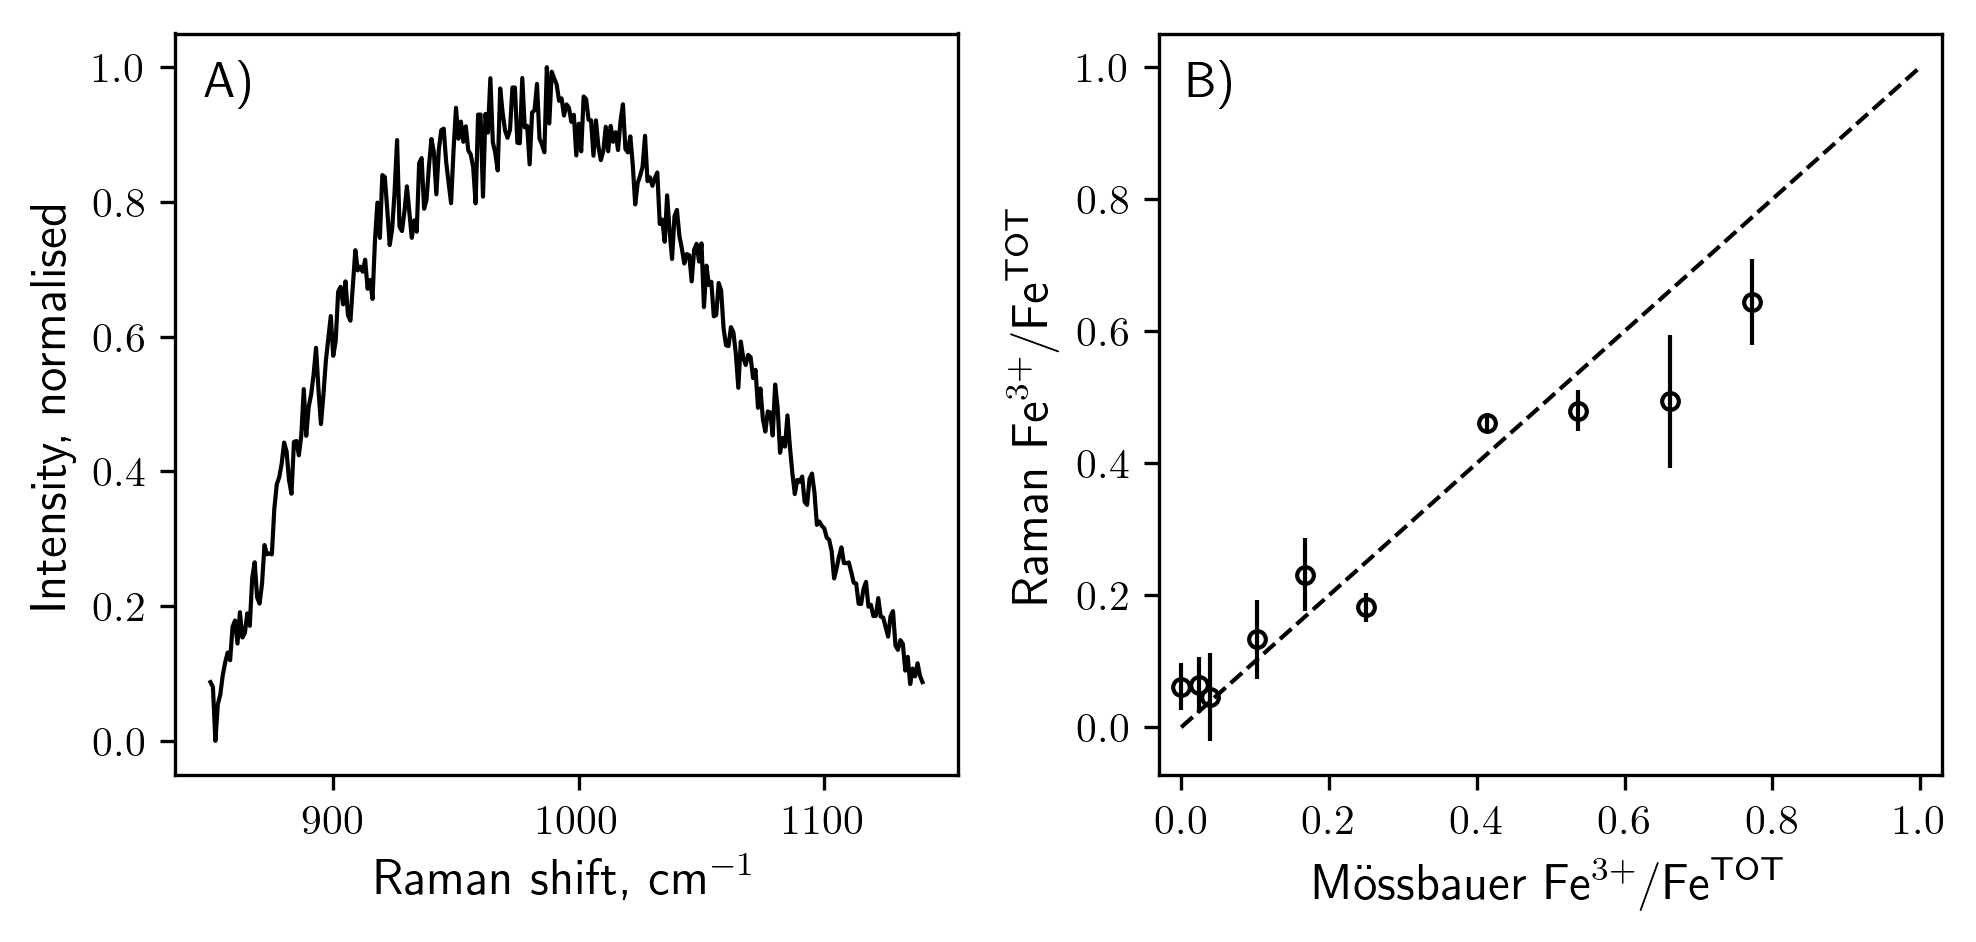

In [16]:
# loading dataset and pre-treatment
liste_T64000 = pd.read_excel("./MORB_datalist.xlsx", sheet_name="T64000")

# preparing the data for the standards
x_t64, t64_record, bas2_t64, x_fit_t64, y_t64_nosmo, y_t64, nb_exp_t64 = iron.preparing_data(liste_T64000,
                                                                                            cutoff=np.array([850.,1140.]))

#
# Intensity Method
#
I930_t64 = iron.intensity(x_fit_t64,y_t64, idx1=929.,idx2=931.)

fe3_t64_900 = un.nominal_values(rp.linear(I930_t64,*params_I))

#
# Mixing with extremum spectra
#
fe3_t64_mix = rp.mixing_sp(y_t64,oxy_ref,red_ref)

#
# Mixing with ALS MCR spectra
#
Cox_t64_als = rp.mixing_sp(y_t64,mcrals.ST_opt_[0,:],mcrals.ST_opt_[1,:])
fe3_t64_als = un.nominal_values(rp.linear(Cox_t64_als,*params_MCR))

#
# Supervised Machine learning techniques
#

# predicting
fe3_t64_svr = svr_mod.predict(y_t64.T)
fe3_t64_kr = kr_mod.predict(y_t64.T)
fe3_t64_nn = nn_mod.predict(y_t64.T)

#
# Average values
#
fe3_t64_mean = np.mean(np.concatenate((fe3_t64_900.reshape(-1,1),fe3_t64_mix.reshape(-1,1),fe3_t64_als.reshape(-1,1),
                fe3_t64_svr.reshape(-1,1),fe3_t64_kr.reshape(-1,1),fe3_t64_nn.reshape(-1,1)),axis=1),axis=1)

fe3_t64_std = np.std(np.concatenate((fe3_t64_900.reshape(-1,1),fe3_t64_mix.reshape(-1,1),fe3_t64_als.reshape(-1,1),
                fe3_t64_svr.reshape(-1,1),fe3_t64_kr.reshape(-1,1),fe3_t64_nn.reshape(-1,1)),axis=1),axis=1,ddof=1)

#
# Figure T64000
#
figT64 = plt.figure(figsize=(6.73,3.24),dpi=300)

plt.subplot(1,2,1)
plt.plot(x_fit_t64,y_t64_nosmo[:,0],"k-")#,color=s_m.to_rgba(liste_T64000.fe3_moss[0]))

plt.xlabel(r"Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, normalised")    
plt.annotate("A)",xy=[0.07,0.93],xycoords='axes fraction',ha="center",va="center",fontsize=12)

plt.subplot(1,2,2)

plt.errorbar(liste_T64000.fe3_moss,fe3_t64_mean,yerr=fe3_t64_std,fmt=".",mfc="none",mec="black",color="black")

plt.plot([0,1],[0,1],"k--")
plt.annotate("B)",xy=[0.07,0.93],xycoords='axes fraction',ha="center",va="center",fontsize=12)
plt.xlabel(r"M\"ossbauer Fe$^{3+}$/Fe\textsuperscript{TOT}")
plt.ylabel(r"Raman Fe$^{3+}$/Fe\textsuperscript{TOT}")
plt.xlim(-0.03,1.03)
plt.tight_layout()

#
# Noise calculation
#

ese_noise_t64 = np.sqrt(np.sum((y_t64-y_t64_nosmo)**2/y_t64.shape[0],axis=0))
ese_fe_t64 = np.sqrt(mean_squared_error(liste_T64000.fe3_moss,fe3_t64_mean))

ese_noise_standards = np.sqrt(np.sum((y_fit-y_fit_nosmo)**2/y_fit.shape[0],axis=0))

SN_t64 = 1.0/np.mean(ese_noise_t64)
SN_renishaw = 1.0/np.mean(ese_noise_standards)

print("Mean signal/noise of spectra acquired on the T64000 : %.2f" % SN_t64)
print("Mean signal/noise of spectra acquired on the Renishaw : %.2f" % SN_renishaw)

print("Mean error on Fe3+/FeTOT with the T64000 : %.2f" % np.mean(ese_fe_t64))
print("Mean error on Fe3+/FeTOT with the Renishaw : %.2f" % np.mean(MSE_tot))
print("\nIn the figure: \nA) is an example of a spectrum acquired with the T64000; \nB) is a plot of predicted (average of the six methods) versus measured Fe3+/FeTOT")

# Prediction of the Fe redox ratio in natural MORB glasses

Spectra acquired on natural MORB glasses are reviewed in a supplementary figure. Spectra without trace of crystal signals are kept. They are then pre-processed, and analysis of the redox is done using them.

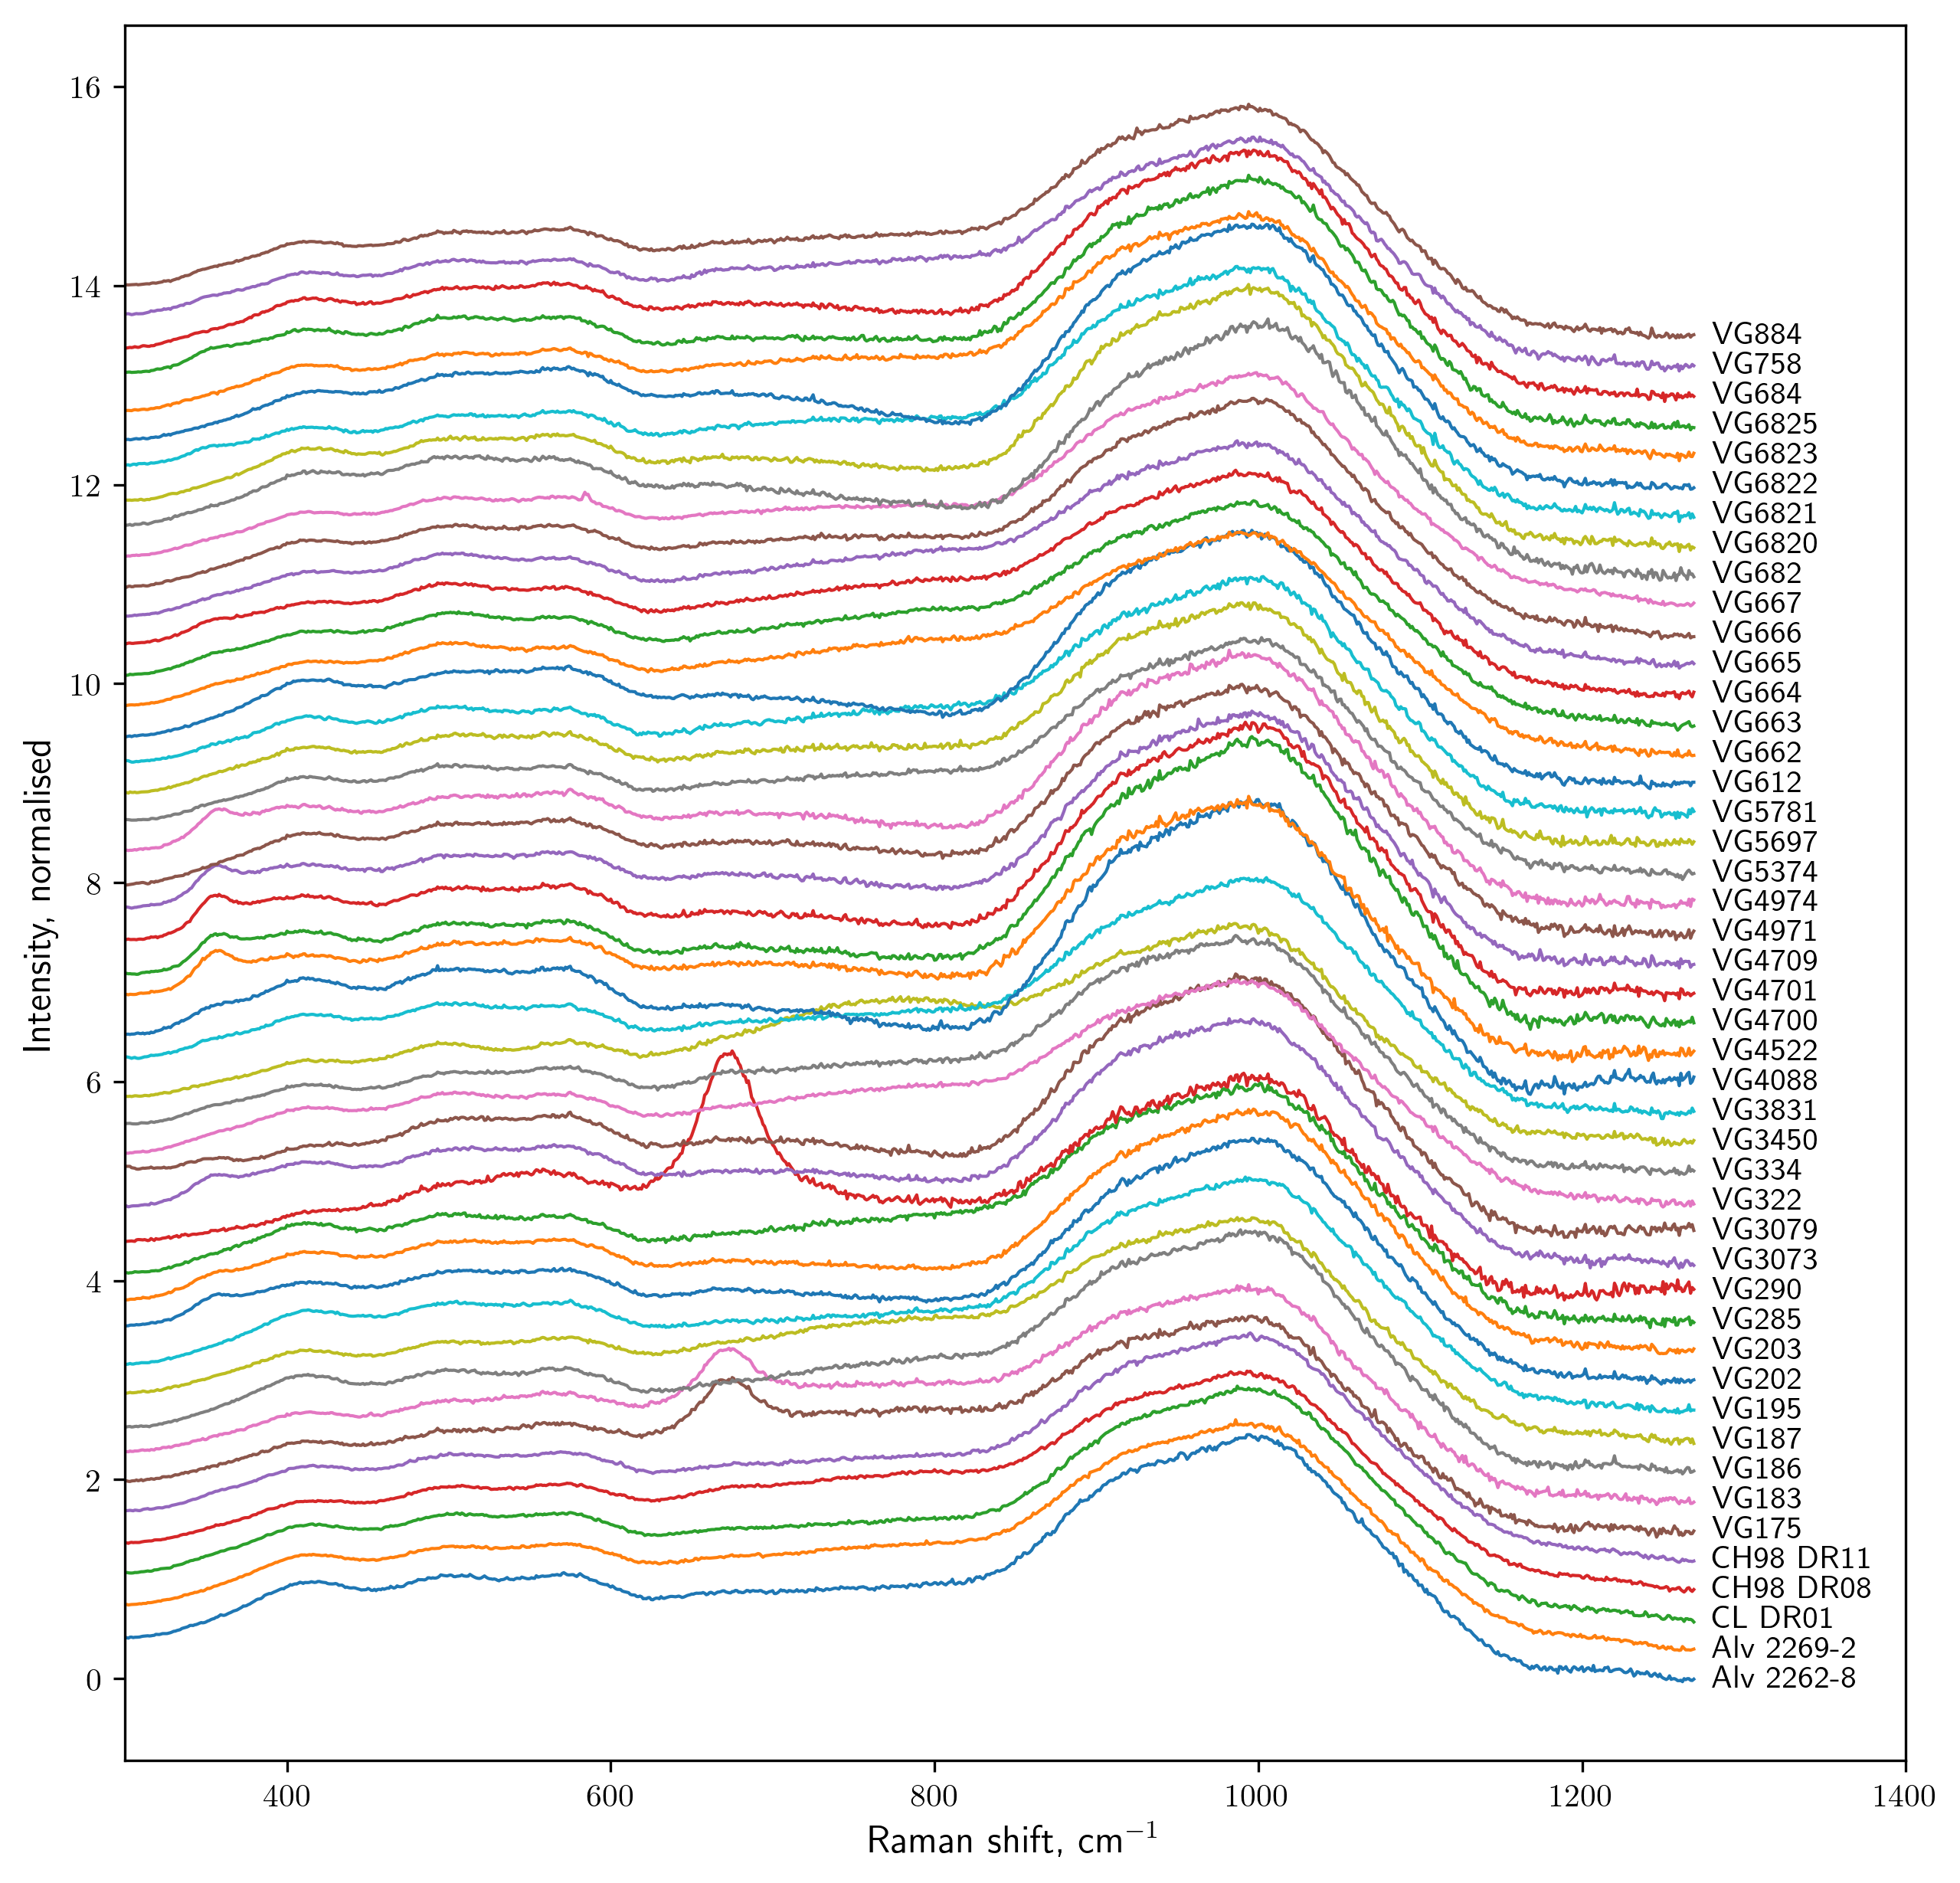

(210, 12)
We kept 42 natural samples.
Correlation coefficient between X and Y in fig. 8B:
[[1.         0.73096425]
 [0.73096425 1.        ]]

{'NN': 0.1518584083890708, 'NN_ese': 0.1173895026432017, 'SVR': 0.15801166213020787, 'SVR_ese': 0.11389420038256068, 'KRR': 0.12715586423378297, 'KRR_ese': 0.11307073471026288, 'I_930': 0.11637954290323088, 'I_930_ese': 0.11886348849249553, 'Mixing': 0.1623129359596672, 'Mixing_ese': 0.10645283381611159, 'ALSMCR': 0.17397072744570038, 'ALSMCR_ese': 0.10961853328876119}

###########################

Fe3+/FeTOT calculated with all methods (no chemical correction):
 average and standard deviations for natural MORB glasses are 0.15 and 0.11, respectively

Correlation coefficient between IFS(M) and I_930:
[[1.         0.82927129]
 [0.82927129 1.        ]]

Parameters of eq. 6 are:
K0 0.111+/-0.027
K1 0.2435+/-0.0023
K2 0.00624+/-0.00029

Chemistry-corrected Raman redox of natural MORBs is now:
Mean: 0.090
Std: 0.067


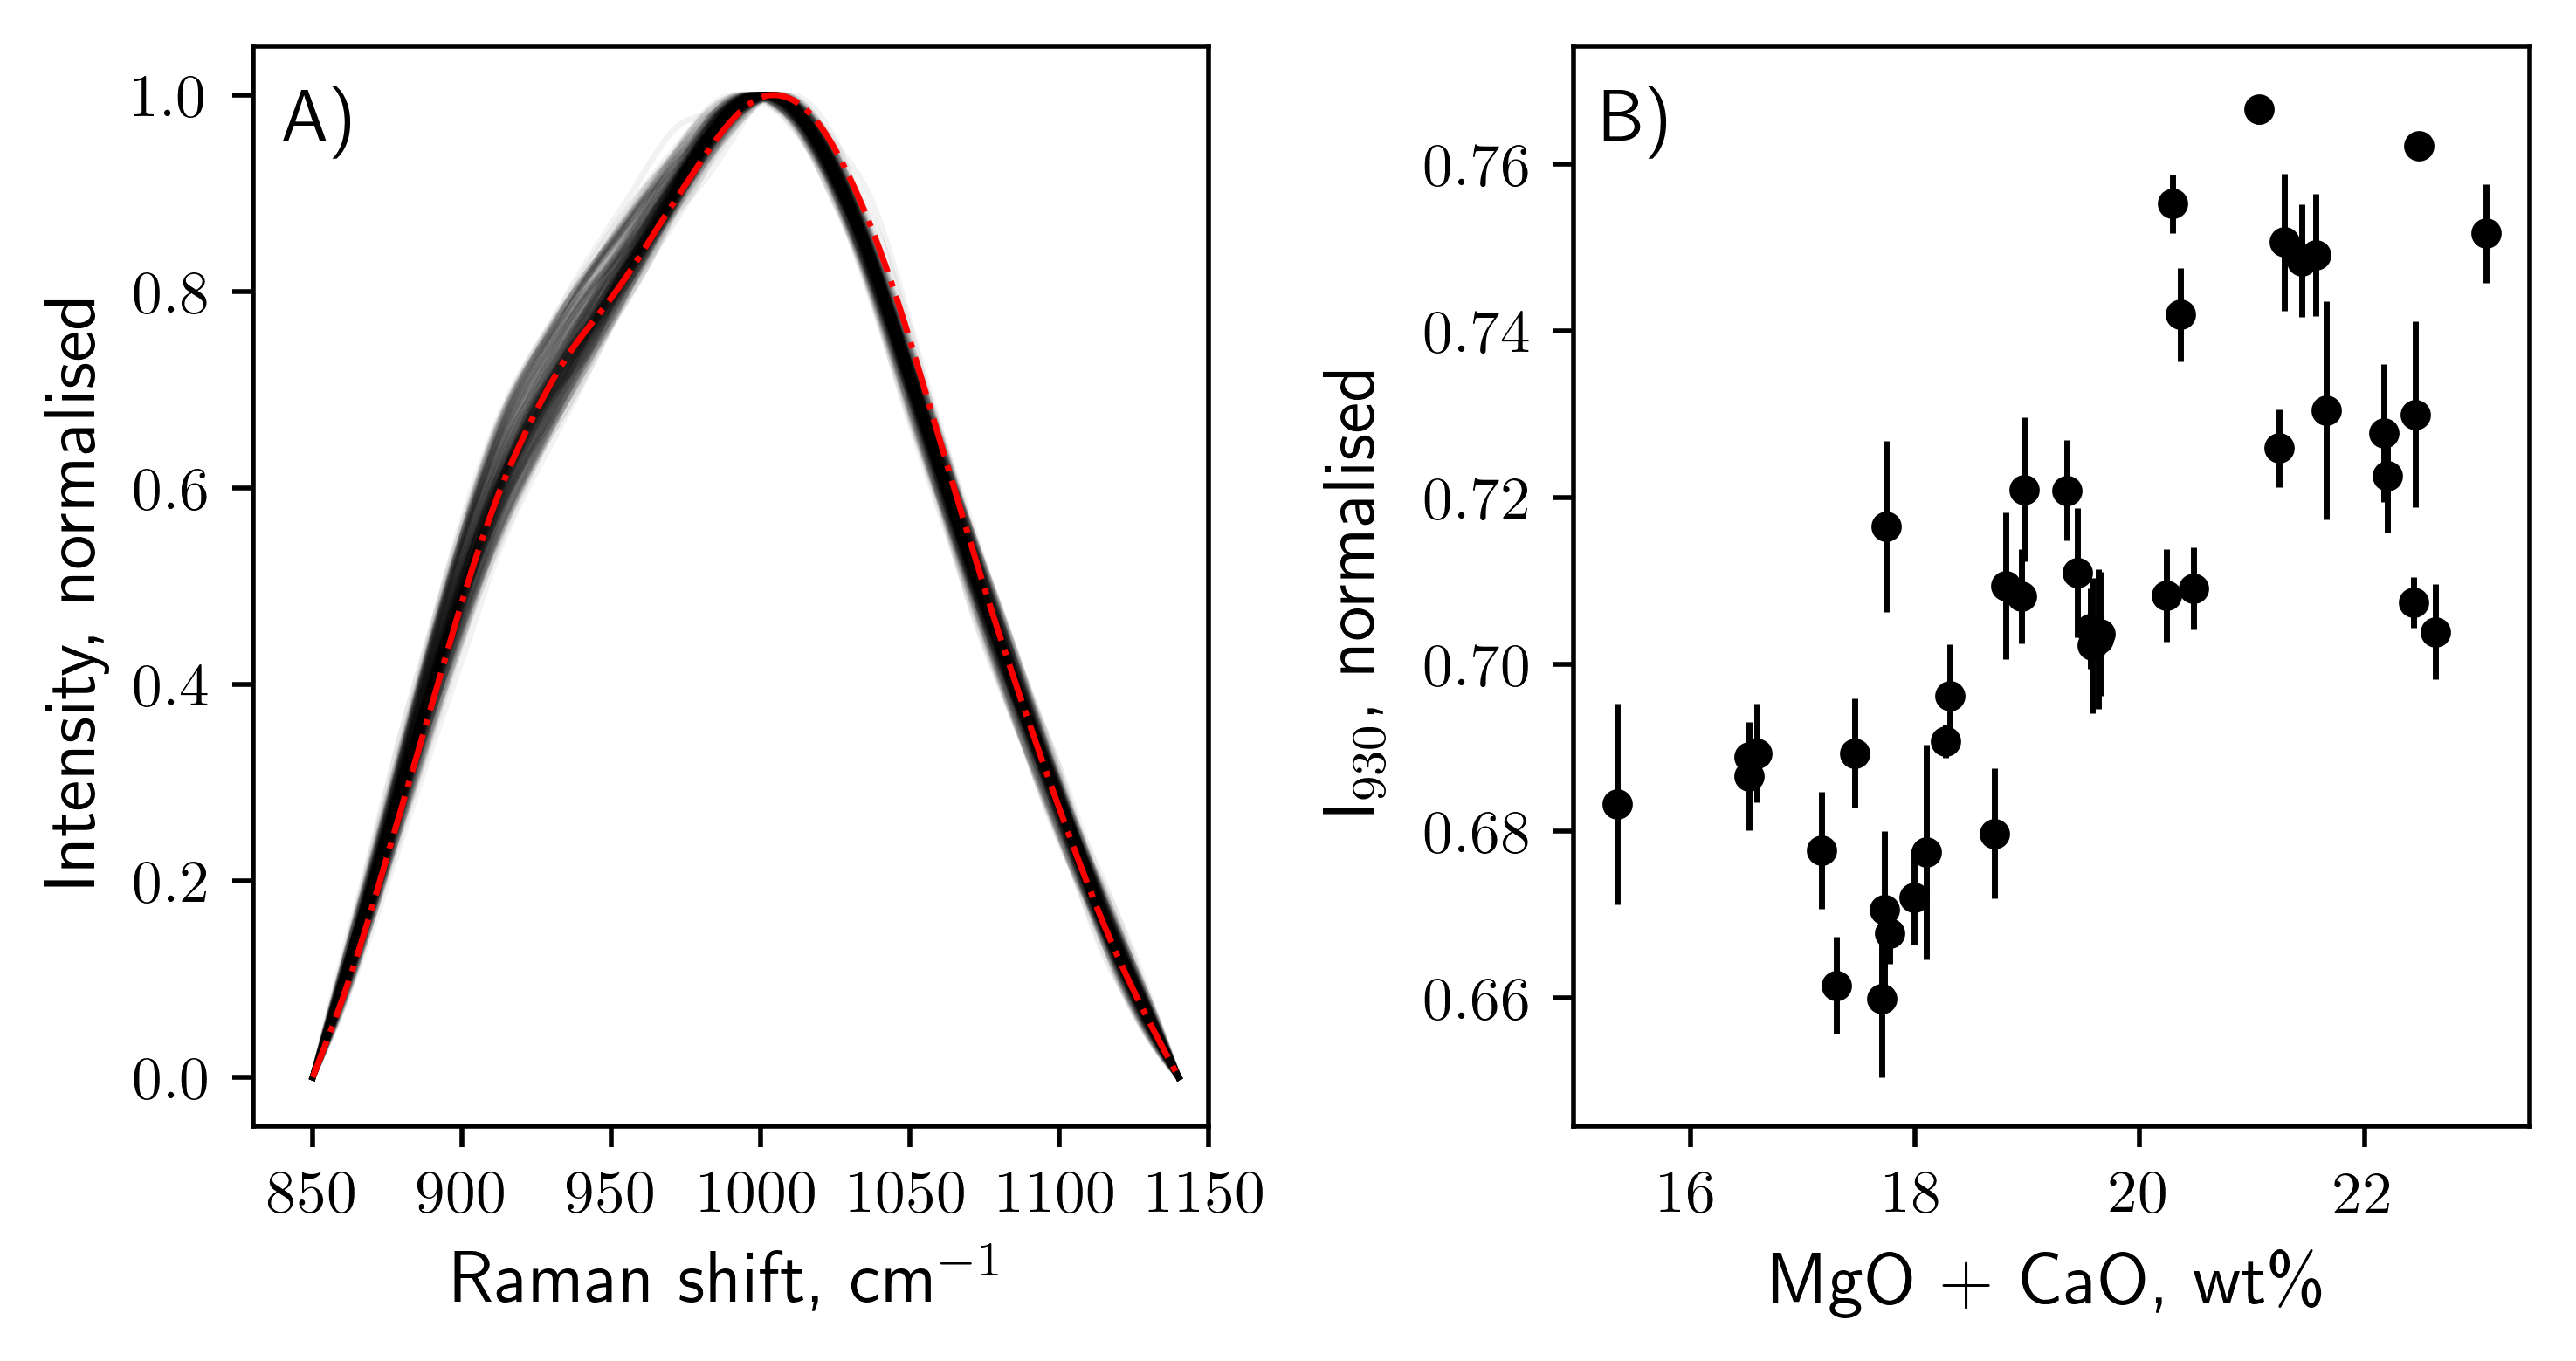

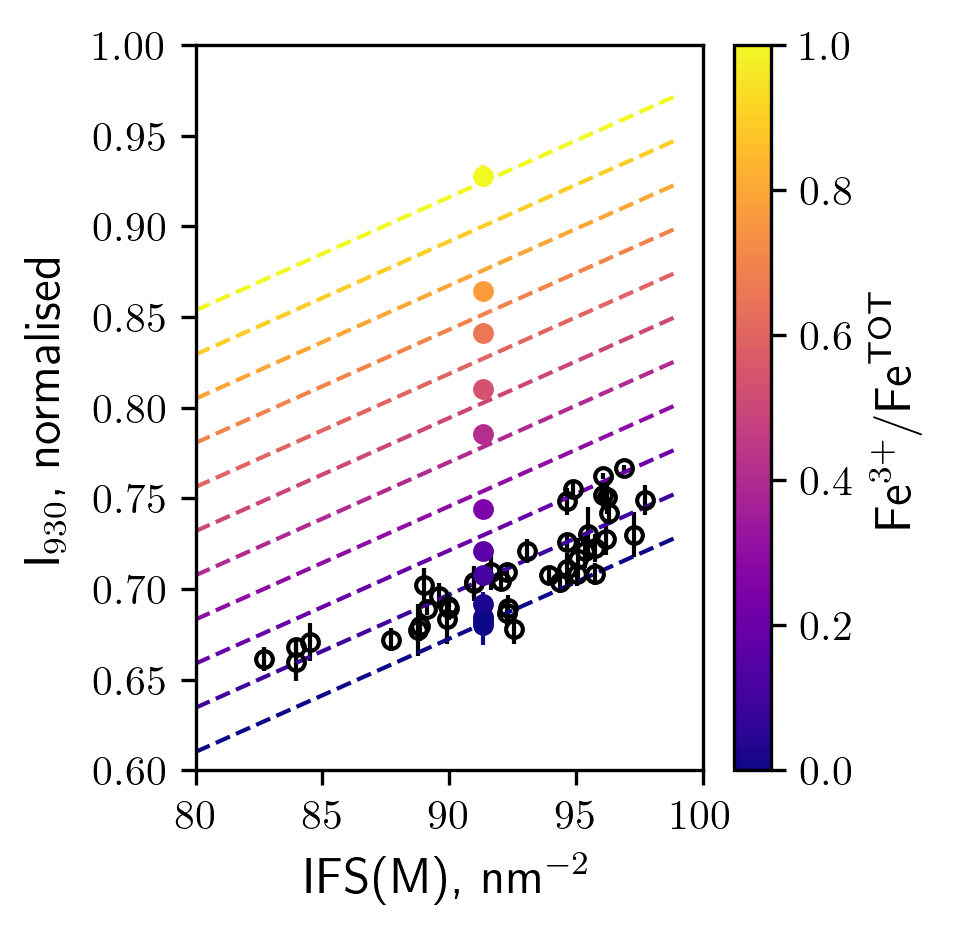

In [17]:
# loading dataset and pre-treatment
liste_standards = pd.read_excel("./MORB_datalist.xlsx", sheet_name="standards") # we reload the standard list for safety

liste_ori = pd.read_excel("./MORB_datalist.xlsx", sheet_name="natural")

# preparing the data
x_nat, natural_record, bas2_nat, x_fit_nat, y_natural_nosmo, y_natural, nb_exp_nat = iron.preparing_data(liste_ori,
                                                                                                        cutoff=np.array([850.,1140.]))

#
# Supplementary Figure
#
plt.figure(figsize=(10,10),dpi=300)
shift = 0
for i in range(0,natural_record.shape[1],5):
    plt.plot(x_nat[x_nat<1270],np.mean(natural_record[x_nat<1270,i:i+5],axis=1)+shift)
    
    plt.annotate(liste_ori.loc[i,"sample"],xy=(1280.,shift),va="center")
    
    shift += 0.3
    
plt.xlabel(r"Raman shift, cm$^{-1}$"); plt.ylabel("Intensity, normalised")

plt.xlim(300,1400)
plt.show()

# exclude the following samples based on previous figure (too much CTX)

liste_natural = liste_ori[liste_ori["sample"] != "VG290"] # Ctx
liste_natural = liste_natural[liste_natural["sample"] != "VG3450"] # weird peak 800
liste_natural = liste_natural[liste_natural["sample"] != "VG175"] # ctx
liste_natural = liste_natural[liste_natural["sample"] != "VG183"] # ctx

# shape should be smaller if success
print(liste_natural.shape)

#
# Re-preparing the data for redox analysis
#

x_nat, natural_record, bas2_nat, x_fit_nat, y_natural_nosmo, y_natural, nb_exp_nat = iron.preparing_data(liste_natural,
                                                                                                        cutoff=np.array([850.,1140.]))

# number of natural samples
print("We kept %i natural samples." % int(nb_exp_nat/5))

liste_natural.index = range(nb_exp_nat)

#
# mean spectra per sample
#
mean_y_nat = np.ones((y_natural.shape[0],int(nb_exp_nat/5)))
counter = 0
for i in range(0,nb_exp_nat,5):
    mean_y_nat[:,counter]=np.mean(y_natural[:,i:i+5],1)
    counter = counter+1

#
# intensity at 930
#
I930_nat = iron.intensity(x_fit_nat,y_natural, idx1=929.,idx2=931.)
I930_nat_mean = iron.intensity(x_fit_nat,mean_y_nat, idx1=929.,idx2=931.)

#
# figure 8
#
plt.figure(figsize=(6,3.22),dpi=500)

plt.subplot(1,2,1)

plt.plot(x_fit_nat,
             y_natural[:,:],
             color="k",
            alpha=0.05)

plt.plot(x_fit,
        mean_y_fit[:,mean_fe3==0.103],"r-.")

plt.xlabel(r"Raman shift, cm$^{-1}$"); plt.ylabel("Intensity, normalised")

plt.xticks([850,900,950,1000,1050,1100,1150])
plt.xlim(830,1150)

plt.annotate("A)",xy=[0.07,0.93],xycoords="axes fraction",ha="center",va="center",fontsize=12)

plt.tight_layout()

plt.subplot(1,2,2)

for i in range(0,nb_exp_nat,5):
    plt.errorbar(liste_natural.loc[i,"mgo"]+liste_natural.loc[i,"cao"],np.mean(I930_nat[i:i+5]),yerr=np.std(I930_nat[i:i+5]),fmt=".",color="k")


plt.xlabel(r"MgO + CaO, wt\%")
plt.ylabel(r"I$_{930}$, normalised")
#plt.xlim(-0.03,1.03)

plt.annotate("B)",xy=[0.07,0.93],xycoords="axes fraction",ha="center",va="center",fontsize=12)

plt.tight_layout()

plt.savefig("./figures/Figure8.pdf")

print("Correlation coefficient between X and Y in fig. 8B:")
print(np.corrcoef(liste_natural["mgo"]+liste_natural["cao"],I930_nat))
print("")

#
# Calculation of the associated Fe3+/FeTOT with previous methods
#


# Intensity Method
fe3_nat_900 = un.nominal_values(rp.linear(I930_nat,*params_I))

# Mixing with extremum spectra
fe3_nat_mix = rp.mixing_sp(y_natural,oxy_ref,red_ref)

# Mixing with ALS MCR spectra
Cox_nat_als = rp.mixing_sp(y_natural,mcrals.ST_opt_[0,:],mcrals.ST_opt_[1,:])
fe3_nat_als = un.nominal_values(rp.linear(Cox_nat_als,*params_MCR))

# Supervised Machine learning techniques
fe3_nat_svr = svr_mod.predict(y_natural.T)
fe3_nat_kr = kr_mod.predict(y_natural.T)
fe3_nat_nn = nn_mod.predict(y_natural.T)

# A dictionary recording the mean and standard deviation of each technique
df_ratios_nat = dict(
NN=np.mean(fe3_nat_nn),NN_ese=np.std(fe3_nat_nn,ddof=1),
SVR = np.mean(fe3_nat_svr), SVR_ese=np.std(fe3_nat_svr,ddof=1),
KRR = np.mean(fe3_nat_kr), KRR_ese=np.std(fe3_nat_kr,ddof=1),
I_930 = np.mean(fe3_nat_900), I_930_ese=np.std(fe3_nat_900,ddof=1),
Mixing = np.mean(fe3_nat_mix), Mixing_ese=np.std(fe3_nat_mix,ddof=1),
ALSMCR = np.mean(fe3_nat_als), ALSMCR_ese=np.std(fe3_nat_als,ddof=1))
print(df_ratios_nat)

mean_fe3_MORB = np.mean(np.vstack((fe3_nat_nn.T,fe3_nat_svr.T,fe3_nat_kr.T,fe3_nat_900,fe3_nat_mix,fe3_nat_als)))
ese_fe3_MORB = np.std(np.vstack((fe3_nat_nn.T,fe3_nat_svr.T,fe3_nat_kr.T,fe3_nat_900,fe3_nat_mix,fe3_nat_als)),ddof=1)
print("\n###########################")
print("\nFe3+/FeTOT calculated with all methods (no chemical correction):\n average and standard deviations for natural MORB glasses are %.2f and %.2f, respectively"% (mean_fe3_MORB, ese_fe3_MORB))

#
# Correction for the effect of chemistry
#

#### calculating chemistry in mol%
chem = iron.chimie_control(liste_standards)
chem = iron.wt_mol(chem)

# naturals
chem_nat = iron.chimie_control(liste_natural)
chem_nat = iron.wt_mol(chem_nat)

#### calculating MgCa parameter as a function of IFS

# declaration of ionic field strength for each cation, in nm^-2
ifs_na = 1.0/(0.110**2) # CN6, Whittaker et Muntus 1970
ifs_k = 1.0/(0.146**2)  # CN6, Whittaker et Muntus 1970
ifs_ca = 2.0/(0.108**2) # CN6, Whittaker et Muntus 1970
ifs_mg = 2.0/(0.080**2) # CN6, Whittaker et Muntus 1970
ifs_fe2 = 2.0/(0.080**2) # CN6, Whittaker et Muntus 1970

ifs_si = 4.0/(0.026**2) # CN4, Whittaker et Muntus 1970
ifs_ti = 4.0/(0.069**2) # CN4, Whittaker et Muntus 1970
ifs_al = 3.0/(0.039**2) # CN4, Whittaker et Muntus 1970

#### STANDARDS
chem_tot = chem["sio2"]+chem["al2o3"]+chem["tio2"]+chem["na2o"]+chem["k2o"]+chem["mgo"]+chem["cao"]+chem["feo"]
chem_m = chem["na2o"]+chem["k2o"]+chem["mgo"]+chem["cao"]+chem["feo"]

sio2_std =  chem["sio2"]/chem_tot
al2o3_std =  chem["al2o3"]/chem_tot
tio2_std =  chem["tio2"]/chem_tot

na2o_std =  chem["na2o"]/chem_tot
k2o_std =  chem["k2o"]/chem_tot
mgo_std =  chem["mgo"]/chem_tot
cao_std = chem["cao"]/chem_tot
feo_std = chem["feo"]/chem_tot

ifst_std = sio2_std *ifs_si + 2*al2o3_std*ifs_al + tio2_std*ifs_ti 
ifsm_std = 2*na2o_std *ifs_na + 2*k2o_std*ifs_k    + cao_std*ifs_ca + mgo_std*ifs_mg + feo_std*ifs_fe2

#### NATURAL MORBS
chem_nat_tot = chem_nat["sio2"]+chem_nat["al2o3"]+chem_nat["tio2"]+chem_nat["na2o"]+chem_nat["k2o"]+chem_nat["mgo"]+chem_nat["cao"]+chem_nat["feo"]
chem_nat_m = chem_nat["na2o"]+chem_nat["k2o"]+chem_nat["mgo"]+chem_nat["cao"]+chem_nat["feo"]

sio2_nat =  chem_nat["sio2"]/chem_nat_tot
al2o3_nat =  chem_nat["al2o3"]/chem_nat_tot
tio2_nat =  chem_nat["tio2"]/chem_nat_tot

na2o_nat =  chem_nat["na2o"]/chem_nat_tot
k2o_nat =  chem_nat["k2o"]/chem_nat_tot
mgo_nat =  chem_nat["mgo"]/chem_nat_tot
cao_nat = chem_nat["cao"]/chem_nat_tot
feo_nat = chem_nat["feo"]/chem_nat_tot

ifst_nat = sio2_nat *ifs_si + 2*al2o3_nat*ifs_al + tio2_nat*ifs_ti
ifsm_nat = 2*na2o_nat*ifs_na  + 2*k2o_nat*ifs_k    + cao_nat*ifs_ca + mgo_nat*ifs_mg + feo_nat*ifs_fe2

#
#### DEFINITION OF THE VARIABLE THAT IS USED IN CALIBRATION
#
IFS_MT_std = ifsm_std
IFS_MT_nat = ifsm_nat

print("\nCorrelation coefficient between IFS(M) and I_930:")
print(np.corrcoef(IFS_MT_nat,I930_nat))

popt_K01, pcov_K01 = op.curve_fit(rp.linear,fe3_standards,I930_std)
popt_K02, pcov_K02 = op.curve_fit(rp.linear,IFS_MT_nat,I930_nat)

params_K01 = uncertainties.correlated_values(popt_K01, pcov_K01)
params_K02 = uncertainties.correlated_values(popt_K02, pcov_K02)

# K0 corrected by difference of Y at the IFS_MT of the standard
K0_ = params_K02[0]-(rp.linear(IFS_MT_std[0],*params_K02)-params_K01[0])
K1_ = params_K01[1] # slope of the Fe3 vs I930 relationship
K2_ = params_K02[1] # slope of the IFS vs I930 relationship

print("\nParameters of eq. 6 are:")
print("K0 "+str(K0_))
print("K1 "+str(K1_))
print("K2 "+str(K2_))

#
# Figure 9
#

# construct the isoredox curves
model_ifs = np.arange(80, 100,1.0)
model_redox = np.arange(0,1.1,0.1)

plt.figure(figsize=(3.22,3.22),dpi=300)

for i in range(0,len(IFS_MT_nat),5):
    plt.errorbar(np.mean(IFS_MT_nat[i:i+5]),
                 np.mean(I930_nat[i:i+5]),
                 yerr=np.std(I930_nat[i:i+5],ddof=1),fmt=".",color="k",mfc="none")
    
for i in range(0,len(IFS_MT_std),5):
    plt.errorbar(np.mean(IFS_MT_std[i:i+5]),
                 np.mean(I930_std[i:i+5]),
                 yerr=np.std(I930_std[i:i+5],ddof=1),
                 fmt=".",
                 color=s_m.to_rgba(fe3_standards[i]))
    
for i in range(len(model_redox)):
    plt.plot(model_ifs,
            un.nominal_values((K0_+model_redox[i]*K1_) + K2_*model_ifs),
             "--",
             color=s_m.to_rgba(model_redox[i])) # calling the ScalarMappable that was initialised with c_m and norm

c_bar = plt.colorbar(s_m) # we plot the colorbar, using again our ScalarMappable
c_bar.set_label(r"Fe$^{3+}$/Fe\textsuperscript{TOT}")

plt.xticks([80,85,90,95,100])
plt.xlim(80,100)
plt.ylim(0.6,1.0)
plt.xlabel(r"IFS(M), nm$^{-2}$")
plt.ylabel(r"I$_{930}$, normalised")
plt.tight_layout()

plt.savefig("./figures/Figure9.pdf")

print("\nChemistry-corrected Raman redox of natural MORBs is now:")
fe_nat_corrected = un.nominal_values((I930_nat-K2_*IFS_MT_nat - K0_)/K1_)
print("Mean: %.3f" % np.mean(fe_nat_corrected))
print("Std: %.3f"% np.std(fe_nat_corrected,ddof=1))

# ML prediction of MORB composition

In the following we use a neural network to predict MORB glass composition from MORB Raman spectra.

Note that results will vary from one run to another because the randim seed is not fixed.

In [40]:
#
# train-test splitting
#

train_nat, test_nat, idxtrain_nat, idxtest_nat = rp.chemical_splitting(liste_natural,'sio2',split_fraction=0.3)

y_train_nat = liste_natural.loc[idxtrain_nat[0],["sio2","al2o3","tio2","feo","mgo","cao","na2o","k2o"]]
X_train_nat = y_natural[:,idxtrain_nat[0]]

y_test_nat = liste_natural.loc[idxtest_nat[0],["sio2","al2o3","tio2","feo","mgo","cao","na2o","k2o"]]
X_test_nat = y_natural[:,idxtest_nat[0]]

#
# scaling
#

X_scaler_nat = sklearn.preprocessing.StandardScaler()
Y_scaler_nat = sklearn.preprocessing.StandardScaler()

X_scaler_nat.fit(X_train_nat.T)
Y_scaler_nat.fit(y_train_nat)

# scaling the data in all cases, it may not be used during the fit later
X_train_nat_sc = X_scaler_nat.transform(X_train_nat.T)

X_test_nat_sc = X_scaler_nat.transform(X_test_nat.T)

#
# parameters for neural net
#

# 1 layer, tanh activation units, solver lbfgs, early stopping on
prm_nn_nat = dict(hidden_layer_sizes=(20,),solver = 'lbfgs',
                  alpha=.1,activation='relu',max_iter=1000)

#
# declaring our neural net object and the bagging regressor, see example at https://github.com/charlesll/rampy/blob/master/examples/Machine%20Learning%20Regression.ipynb
#

nn_ = MLPRegressor(**prm_nn_nat)

#
# TRAINING
#
nn_.fit(X_train_nat_sc,y_train_nat)

#
# PREDICTIONS
#
y_test_nat_pred = nn_.predict(X_test_nat_sc)
y_train_nat_pred = nn_.predict(X_train_nat_sc)


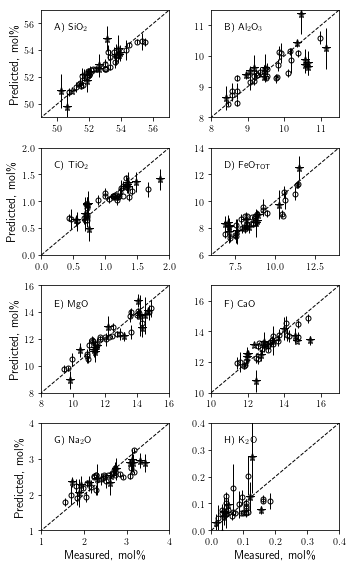

In [41]:
list_chemicals = [r"A) SiO$_2$",r"B) Al$_2$O$_3$",r"C) TiO$_2$",r"D) FeO$\textsubscript{TOT}$",
                  r"E) MgO",r"F) CaO",r"G) Na$_2$O",r"H) K$_2$O"]

low_lims = [0.49,0.08,0.00,0.06,0.08,0.10,0.01,0.]
high_lims = [0.57,0.115,0.020,0.14,0.16,0.17,0.04,0.004]

plt.figure(figsize=(5,8))
for i in range(8):
    plt.subplot(4,2,i+1)
    
    
    for j in range(0,y_train_nat_pred.shape[0],5):
        plt.errorbar(y_train_nat.iloc[j,i]*100,
                     np.mean(y_train_nat_pred[j:j+5,i]*100),
                     yerr=np.std(y_train_nat_pred[j:j+5,i]*100,ddof=1),
                     fmt="o",color="k",mfc="none",ms=5)
    
    for j in range(0,y_test_nat_pred.shape[0],5):
        plt.errorbar(y_test_nat.iloc[j,i]*100,
                     np.mean(y_test_nat_pred[j:j+5,i]*100),
                     yerr=np.std(y_test_nat_pred[j:j+5,i]*100,ddof=1),
                     fmt="*",color="k",mfc="none")
    plt.plot([0,100],[0,100],"k--")
    plt.xlim(low_lims[i]*100,high_lims[i]*100)
    plt.ylim(low_lims[i]*100,high_lims[i]*100)
    
    plt.annotate(list_chemicals[i],xy=(0.1,0.8),xycoords="axes fraction")
    
    if i == 6 or i == 7:
        plt.xlabel("Measured, mol\%")
        
    if i % 2 == 0:
        plt.ylabel("Predicted, mol\%")
plt.tight_layout()



# CONTINUE TRAINING

We try to re-train to improve a bit the results

In [46]:
nn_.fit(X_train_nat_sc,y_train_nat)

#
# PREDICTIONS
#
y_test_nat_pred = nn_.predict(X_test_nat_sc)
y_train_nat_pred = nn_.predict(X_train_nat_sc)

print("Training error is: %.5f" %np.sqrt(mean_squared_error(y_train_nat_pred,y_train_nat)))
print("Testing error is: %.5f" %np.sqrt(mean_squared_error(y_test_nat_pred,y_test_nat)))

Training error is: 0.00343
Testing error is: 0.00670


# Figure 10

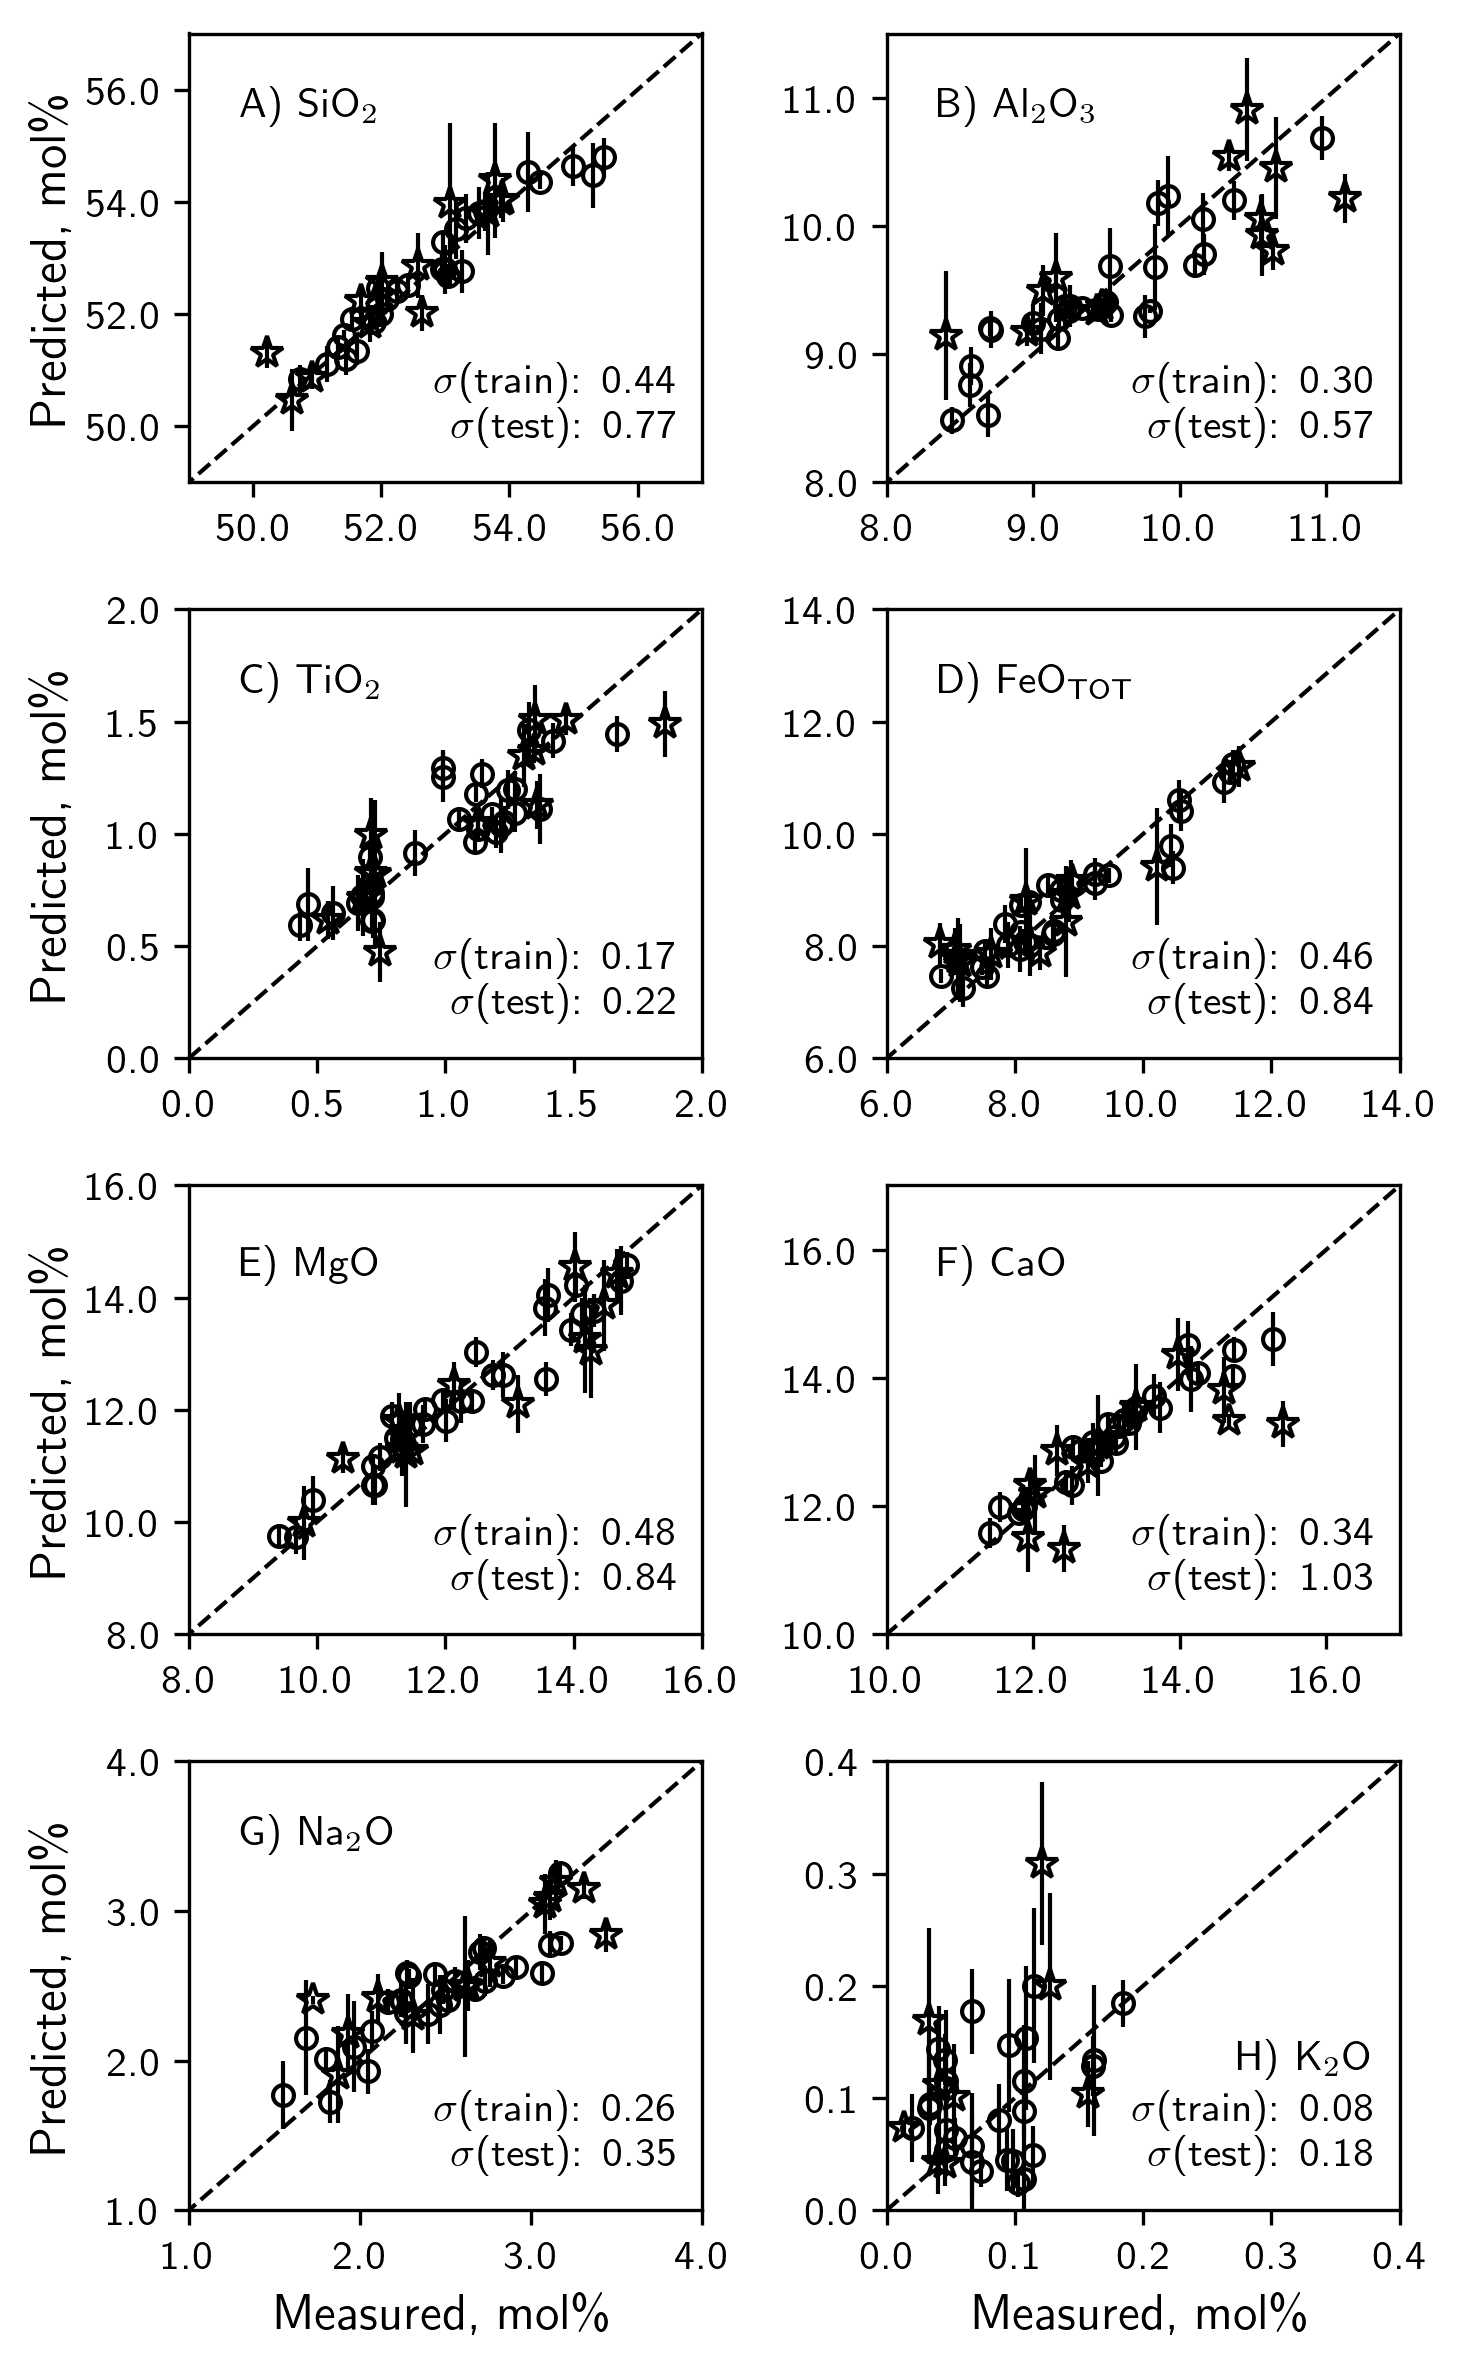

In [53]:
# we re-do the figure with the newly trained network
# we add errors also in the subplots

ticks = (np.arange(50,58,2.),np.arange(8,12,1),np.arange(0,2.5,0.5),
         np.arange(6,15,2),np.arange(8,18,2),np.arange(10,18,2),
        np.arange(1,5,1),np.arange(0,0.5,0.1))

plt.figure(figsize=(5,8),dpi=300)
for i in range(8):
    ax = plt.subplot(4,2,i+1)
    
    for j in range(0,y_train_nat_pred.shape[0],5):
        plt.errorbar(y_train_nat.iloc[j,i]*100,
                     np.mean(y_train_nat_pred[j:j+5,i]*100),
                     yerr=np.std(y_train_nat_pred[j:j+5,i]*100,ddof=1),
                     fmt="o",color="k",mfc="none",ms=5)
    
    for j in range(0,y_test_nat_pred.shape[0],5):
        plt.errorbar(y_test_nat.iloc[j,i]*100,
                     np.mean(y_test_nat_pred[j:j+5,i]*100),
                     yerr=np.std(y_test_nat_pred[j:j+5,i]*100,ddof=1),
                     fmt="*",color="k",mfc="none")
    plt.plot([0,100],[0,100],"k--")
    
    if i < 7:
        plt.annotate(list_chemicals[i],xy=(0.1,0.8),xycoords="axes fraction")
        plt.annotate("$\sigma$(train): {:.2f}".format(100*np.sqrt(mean_squared_error(y_train_nat_pred[:,i],y_train_nat.iloc[:,i]))),xy=(0.95,0.2),xycoords="axes fraction",ha="right")
        plt.annotate("$\sigma$(test): {:.2f}".format(100*np.sqrt(mean_squared_error(y_test_nat_pred[:,i],y_test_nat.iloc[:,i]))),xy=(0.95,0.1),xycoords="axes fraction",ha="right")
    
    else:
        plt.annotate(list_chemicals[i],xy=(0.95 ,0.3),xycoords="axes fraction",ha="right")
        plt.annotate("$\sigma$(train): {:.2f}".format(100*np.sqrt(mean_squared_error(y_train_nat_pred[:,i],y_train_nat.iloc[:,i]))),xy=(0.95,0.2),xycoords="axes fraction",ha="right")
        plt.annotate("$\sigma$(test): {:.2f}".format(100*np.sqrt(mean_squared_error(y_test_nat_pred[:,i],y_test_nat.iloc[:,i]))),xy=(0.95,0.1),xycoords="axes fraction",ha="right")
    if i == 6 or i == 7:
        plt.xlabel("Measured, mol\%")
        
    if i % 2 == 0:
        plt.ylabel("Predicted, mol\%")
        
    ax.get_yaxis().set_label_coords(-0.22,0.5) # to be sure y axis are at the same level
    from matplotlib.ticker import FormatStrFormatter
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
    plt.xlim(low_lims[i]*100,high_lims[i]*100)
    plt.ylim(low_lims[i]*100,high_lims[i]*100)
    
    plt.xticks(ticks[i])
    plt.yticks(ticks[i])
plt.tight_layout()
plt.savefig("./figures/Figure10.pdf")




# Saving models and Redox values in tables.

Examples of saving things in tables.

Models can also be pickled for exportation, see scikit-learn documentation about this.

### Standards

In [ ]:
fe3_out_standards = {'Intensity': intensity_results[:,2], 
                     'Mixing': Fox_results[:,0], 
                     'ALS MCR': conc_als_mcr_mean[:,2],
                     'NeuralNets': nn_all_mean,
                     'KernelRidge': kr_all_mean,
                     'SVM': svr_all_mean}
df_out = pd.DataFrame(data=fe3_out_standards)
df_out.to_csv('out_table1.csv')

### Table S1

In [ ]:
liste_nat_out = liste_natural.copy()
liste_nat_out_std = liste_natural.copy()

liste_nat_out["Fe3+/FeTOT"] = fe_nat_corrected
liste_nat_out_std["Fe3+/FeTOT"] = fe_nat_corrected

l_o = liste_nat_out.groupby("sample").aggregate("mean")
l_o["ese Fe3+/FeTOT"] = liste_nat_out_std.groupby("sample").aggregate("std").loc[:,"Fe3+/FeTOT"]
l_o.to_csv("TableS1.csv")